# Imports

In [269]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: pho
"""
%load_ext autoreload
%autoreload 2
import sys
import importlib
from threading import Thread
import time # for time.sleep
from ipygany import PolyMesh, Scene, IsoColor, WarpByScalar
import pyvista as pv
# from pyvista import _vtk
import pyvistaqt as pvqt
import colorcet as cc # Colormaps:
import numpy as np
import pandas as pd
from pathlib import Path
import bqplot.scales
import seaborn as sns

#interactive plotting in separate window
# %matplotlib qt
# %matplotlib inline
# %matplotlib notebook $ # Very bad, don't use this one, obsolite
# %matplotlib widget
# %matplotlib qt

from mpl_toolkits import mplot3d
# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize, to_rgba_array
from matplotlib.figure import Figure
# import mplcursors
import math # For color map generation
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

from copy import deepcopy

import ipywidgets as widgets
# from PyQt5 import QtWidgets, uic
from pyvistaqt import QtInteractor, MainWindow
# from pyqt6 import QApplication
from IPython.external.qt_for_kernel import QtGui
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
from IPython.lib.pretty import pretty, pprint
# from pretty import pprint

# Pandas display options
# pd.set_option('display.max_columns', None)  # or 1000
# pd.set_option('display.max_rows', None)  # or 1000
# pd.set_option('display.max_colwidth', -1)  # or 199
pd.set_option('display.width', 1000)


import rich as rich
# from rich import inspect
# from rich import print
# from rich import pretty

from PyQt5.QtWidgets import QApplication
import datetime as dt

## Panel:
import param
import panel as pn
# from panel.interact import interact, interactive, fixed, interact_manual
# from panel import widgets
pn.extension()
# pn.extension('tabulator')

# from ipywidgets import interact
# # interact
# @interact


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# NeuroPy (Diba Lab Python Repo) Loading
try:
    from neuropy import core
    importlib.reload(core)
except ImportError:
    sys.path.append(r'C:\Users\Pho\repos\NeuroPy') # Windows
    # sys.path.append('/home/pho/repo/BapunAnalysis2021/NeuroPy') # Linux
    # sys.path.append(r'/Users/pho/repo/Python Projects/NeuroPy') # MacOS
    print('neuropy module not found, adding directory to sys.path. \n >> Updated sys.path.')
    from neuropy import core
# from neuropy.core.session.dataSession import SessionConfig, DataSessionLoader, DataSession, processDataSssion

# import neuropy.core as core
from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.core.epoch import Epoch
from neuropy.core.epoch import NamedTimerange
from neuropy.core import Laps
from neuropy.core import Position
from neuropy.core import FlattenedSpiketrains
from neuropy.core import Neurons
from neuropy.utils.misc import print_seconds_human_readable
from neuropy.plotting import plot_raster
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.analyses.laps import estimate_laps, compute_laps_spike_indicies
from neuropy.analyses.pho_custom_placefields import PfND
from neuropy.plotting.placemaps import plot_all_placefields

neuropy module not found, adding directory to sys.path. 
 >> Updated sys.path.


In [3]:
# import PhoPositionalData as pdp
# from PhoPositionalData import load_exported, process_data
from PhoPositionalData.load_exported import *
# from PhoPositionalData.process_data import process_positionalAnalysis_data, gen_2d_histrogram, get_heatmap_color_vectors, process_chunk_equal_poritions_data, extract_spike_timeseries
from PhoPositionalData.process_data import *
from PhoPositionalData.plot_data import *
from PhoPositionalData.plotting.animations import * # make_mp4_from_plotter
from PhoPositionalData.plotting.laps import plot_laps_2d
from PhoPositionalData.import_data import * # build_spike_positions_list, build_cellID_reverse_lookup_map
from PhoPositionalData.analysis.interactive_placeCell_config import InteractivePlaceCellConfig, VideoOutputModeConfig, PlottingConfig
from PhoPositionalData.analysis.interactive_placeCell_config import print_subsession_neuron_differences

from PendingNotebookCode import debug_print_spike_counts, compute_placefields_as_needed, build_configs, build_units_colormap, build_placefield_multiplotter, process_by_good_placefields, estimation_session_laps, partition



# Load Session Data

	 basepath: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53
	 session_name: 2006-6-07_11-26-53
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.epochs_info.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position_info.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.spikes.mat...
done.
Failure loading .position.npy. Must recompute.

Computing linear positions for all active epochs for session...
curr_active_epoch_timeslice_indicies: Int64Index([   27,    28,    29,    30,    31,    32,    33,    34,    35,    36,
            ...
            52139, 52140, 52141, 52142, 52143, 52144, 52145, 52146, 52147, 52148], dtype='int64', length=52122)
 	 np.shape(curr_active_epoch_timeslice_indicies): (52122,)
curr_active_epoch_timeslice_indicies: Int64Index([52149, 52150, 52151, 52152, 52153, 52154, 52155, 52156, 52157, 52158,
            ...
            

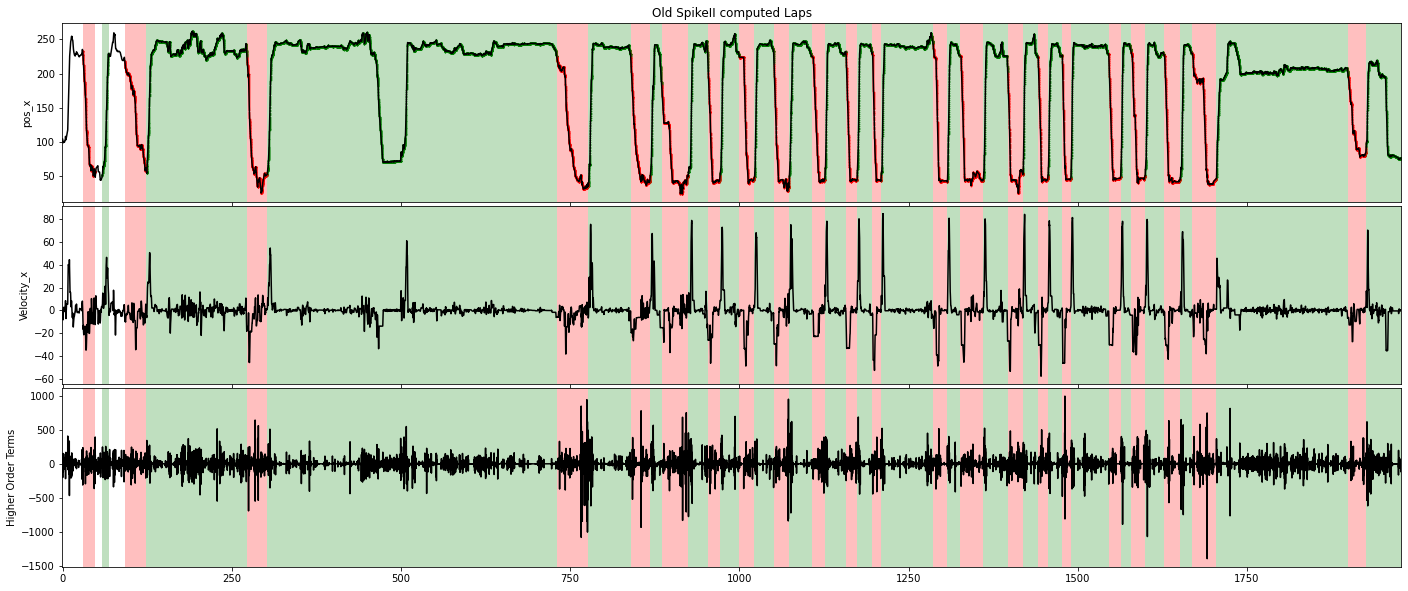

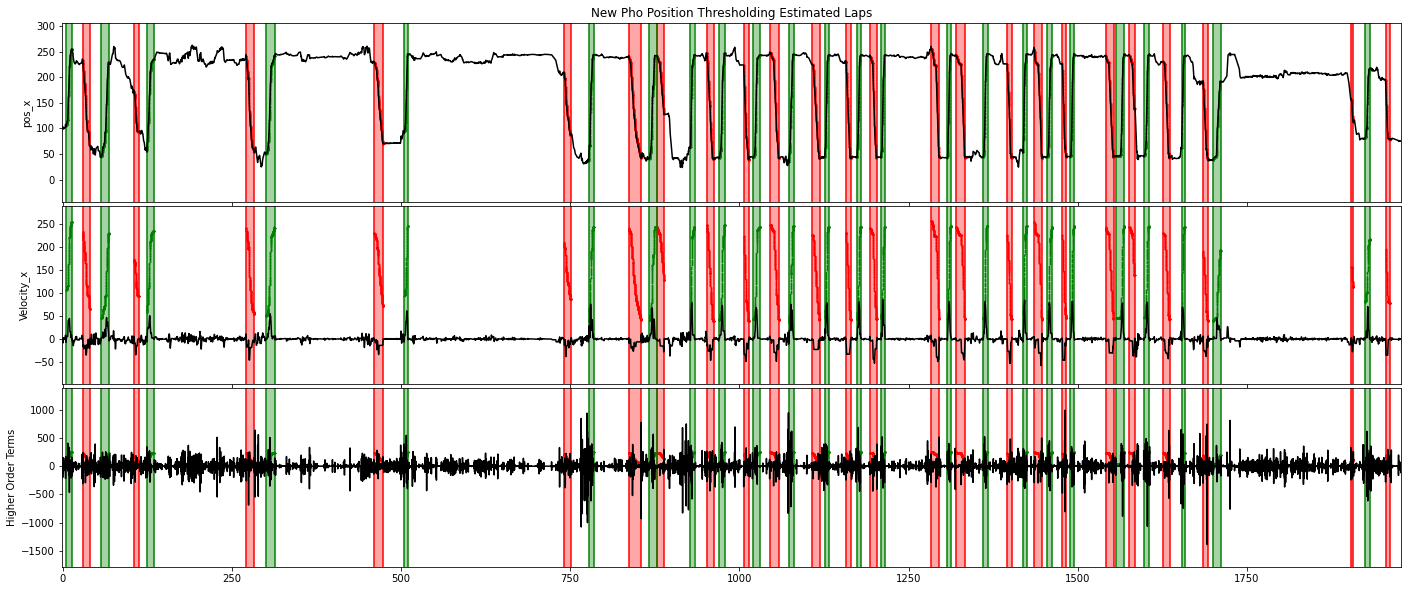

In [4]:
# KDiba Old Format:
## Data must be pre-processed using the MATLAB script located here: 
# R:\data\KDIBA\gor01\one\IIDataMat_Export_ToPython_2021_11_23.m
# From pre-computed .mat files:
# 07: 
basedir = r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53'
# # ## 08:
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-08_14-26-15'
sess = DataSessionLoader.kdiba_old_format_session(basedir)
active_sess_config = sess.config
session_name = sess.name

# sess.spikes_df.size # (1014937, 18)
# np.sum(sess.neurons.n_spikes) # 1014937
print('session dataframe spikes: {}\nsession.neurons.n_spikes summed: {}\n'.format(sess.spikes_df.shape, np.sum(sess.neurons.n_spikes)))

## Estimate the Session's Laps data using my algorithm from the loaded position data.
sess = estimation_session_laps(sess)

### Lap Specific Session Debugging



In [5]:
lap_specific_epochs = sess.laps.as_epoch_obj()
# lap_specific_epochs.to_dataframe()
any_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(len(sess.laps.lap_id))])
even_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(0, len(sess.laps.lap_id), 2)])
odd_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(1, len(sess.laps.lap_id), 2)])

# Filter Session by Epoch:

In [197]:
sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
# sess.epochs.to_dataframe()
# active_epoch = sess.epochs.get_named_timerange('maze1')
# print('active_epoch: {}'.format(active_epoch))
# active_epoch = sess.epochs.get_named_timerange('maze2')
active_epoch = NamedTimerange(name='maze', start_end_times=[sess.epochs['maze1'][0], sess.epochs['maze2'][1]])
active_subplots_shape = (1,1) # Single subplot
# active_subplots_shape = '1|2' # 1 subplot on left, two on right
active_config = build_configs(active_sess_config, active_epoch, active_subplots_shape = active_subplots_shape)

## All Spikes:
active_epoch_session = sess.filtered_by_neuron_type('pyramidal').filtered_by_epoch(active_epoch)
print_subsession_neuron_differences(sess.neurons, active_epoch_session.neurons)
# print(sess.neurons.n_spikes)

# # ## Lap_specific Spikes Only:
# active_lap_specific_epoch_session = lap_specific_session.filtered_by_neuron_type('pyramidal').filtered_by_epoch(active_epoch)
# print_subsession_neuron_differences(lap_specific_session.neurons, active_lap_specific_epoch_session.neurons)
# # print(active_lap_specific_epoch_session.neurons.n_spikes)

## Configure Placefield Calc:
should_display_2D_plots = False
should_save_to_disk = True


# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=2, smooth=0.5, frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=10, smooth=0.5, frate_thresh=2.0) # works well
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=2.5, smooth=1.5, frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(0.5, 0.5), frate_thresh=0.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0.0, grid_bin=(3, 4), smooth=(2, 1), frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 10), smooth=(0.5, 0.5), frate_thresh=2.0) ## Works well for 2D Placemaps
# height: 20.0
# width: 250.0
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0, grid_bin=(2.0, 0.2), smooth=(0.5, 0.5), frate_thresh=2.0) ## Extremely Slow
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0, grid_bin=(2.0, 1.0), smooth=(0.5, 0.5), frate_thresh=2.0) ## Very slow, doesn't work

# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(0.0, 0.0), frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(0.1, 0.1), frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(1.0, 10.0), frate_thresh=2.0)

# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0.0, grid_bin=(25, 9), smooth=(0.0, 0.0), frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0.0, grid_bin=(5, 3), smooth=(0.0, 0.0), frate_thresh=2.0)
active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0.0, grid_bin=(5, 3), smooth=(0.0, 0.0), frate_thresh=0.1) # TODO: FIXME: BUG: when frate_thresh=0.0, there are 0 good placefield_neuronIDs for all computations!


# active_config.computation_config.frate_thresh = 0.0

Constraining to units with type: pyramidal
Constraining to epoch with times (start: 22.26, end: 1932.4200048116618)
77726/932598 total spikes spanning 40/64 units remain in subsession


### TESTING: position binning with _bin_pos_nD testing and validation:

## Compute Placefields if needed:

## Compute the placefields for lap-only filtered Session:

In [198]:
def debug_print_ratemap(ratemap):
    # Get the cell IDs that have a good place field mapping:
    good_placefield_neuronIDs = np.array(ratemap.neuron_ids) # in order of ascending ID
    print('good_placefield_neuronIDs: {}; ({} good)'.format(good_placefield_neuronIDs, len(good_placefield_neuronIDs)))
    
def debug_print_placefield(active_epoch_placefield, short=True):
    # Get the cell IDs that have a good place field mapping:
    good_placefield_neuronIDs = np.array(active_epoch_placefield.ratemap.neuron_ids) # in order of ascending ID
    num_spikes_per_spiketrain = np.array([np.shape(a_spk_train)[0] for a_spk_train in active_epoch_placefield.spk_t])
    if short:
        print('good_placefield_neuronIDs: ({} good)'.format(len(good_placefield_neuronIDs)), end='\n')
        print('num_spikes: ({} total spikes)'.format(np.sum(num_spikes_per_spiketrain)), end='\n')
    else:
        print('good_placefield_neuronIDs: {}; ({} good)'.format(good_placefield_neuronIDs, len(good_placefield_neuronIDs)), end='\n')
        print('num_spikes: {}; ({} total spikes)'.format(num_spikes_per_spiketrain, np.sum(num_spikes_per_spiketrain)), end='\n')
    return pd.DataFrame({'neuronID':good_placefield_neuronIDs, 'num_spikes':num_spikes_per_spiketrain}).T


def compute_placefields_masked_by_epochs(sess, active_config, included_epochs=None, should_display_2D_plots=False):
    active_session = deepcopy(sess)
    active_epoch_placefields1D, active_epoch_placefields2D = compute_placefields_as_needed(active_session, active_config.computation_config, active_config, None, None, included_epochs=included_epochs, should_force_recompute_placefields=True, should_display_2D_plots=should_display_2D_plots)
    # Focus on the 2D placefields:
    # active_epoch_placefields = active_epoch_placefields2D
    # Get the updated session using the units that have good placefields
    # active_session, active_config, good_placefield_neuronIDs = process_by_good_placefields(active_session, active_config, active_epoch_placefields)
    # debug_print_spike_counts(active_session)
    return active_epoch_placefields1D, active_epoch_placefields2D


active_epoch_placefields1D, active_epoch_placefields2D = compute_placefields_masked_by_epochs(active_epoch_session, active_config, included_epochs=None, should_display_2D_plots=should_display_2D_plots)
even_lap_specific_placefields1D, even_lap_specific_placefields2D = compute_placefields_masked_by_epochs(active_epoch_session, active_config, included_epochs=even_lap_specific_epochs, should_display_2D_plots=should_display_2D_plots)
odd_lap_specific_placefields1D, odd_lap_specific_placefields2D = compute_placefields_masked_by_epochs(active_epoch_session, active_config, included_epochs=odd_lap_specific_epochs, should_display_2D_plots=should_display_2D_plots)
any_lap_specific_placefields1D, any_lap_specific_placefields2D = compute_placefields_masked_by_epochs(active_epoch_session, active_config, included_epochs=any_lap_specific_epochs, should_display_2D_plots=should_display_2D_plots)
# Compare the results
# debug_print_ratemap(active_epoch_placefields1D.ratemap)
# num_spikes_per_spiketrain = np.array([np.shape(a_spk_train)[0] for a_spk_train in active_epoch_placefields1D.spk_t])
# num_spikes_per_spiketrain
# print('placefield_neuronID_spikes: {}; ({} total spikes)'.format(num_spikes_per_spiketrain, np.sum(num_spikes_per_spiketrain)))

debug_print_placefield(active_epoch_placefields1D)
debug_print_placefield(any_lap_specific_placefields1D)
debug_print_placefield(even_lap_specific_placefields1D)
debug_print_placefield(odd_lap_specific_placefields1D)

# Get the cell IDs that have a good place field mapping:
active_placefields = deepcopy(any_lap_specific_placefields2D) # not changed this from the default placefields2D object
good_placefield_neuronIDs = np.array(active_placefields.ratemap.neuron_ids) # in order of ascending ID
good_placefield_tuple_neuronIDs = active_placefields.neuron_extended_ids

## Filter by neurons with good placefields only:
good_placefields_session = active_epoch_session.get_by_id(good_placefield_neuronIDs) # Filter by good placefields only, and this fetch also ensures they're returned in the order of sorted ascending index ([ 2  3  5  7  9 12 18 21 22 23 26 27 29 34 38 45 48 53 57])
good_placefields_session
    
pf_sort_ind, pf_colors, pf_colormap, pf_listed_colormap = build_units_colormap(good_placefield_neuronIDs)
active_config.plotting_config.pf_sort_ind = pf_sort_ind
active_config.plotting_config.pf_colors = pf_colors
active_config.plotting_config.active_cells_colormap = pf_colormap
active_config.plotting_config.active_cells_listed_colormap = ListedColormap(active_config.plotting_config.active_cells_colormap)

# active_placefields.ratemap.get_sort_indicies()
    

Recomputing active_epoch_placefields... 	 done.
Recomputing active_epoch_placefields2D... 	 done.
skipping 2D placefield plots
Recomputing active_epoch_placefields... 	 done.
Recomputing active_epoch_placefields2D... 	 done.
skipping 2D placefield plots
Recomputing active_epoch_placefields... 	 done.
Recomputing active_epoch_placefields2D... 	 done.
skipping 2D placefield plots
Recomputing active_epoch_placefields... 	 done.
Recomputing active_epoch_placefields2D... 	 done.
skipping 2D placefield plots
good_placefield_neuronIDs: (40 good)
num_spikes: (77722 total spikes)
good_placefield_neuronIDs: (40 good)
num_spikes: (21997 total spikes)
good_placefield_neuronIDs: (40 good)
num_spikes: (10407 total spikes)
good_placefield_neuronIDs: (40 good)
num_spikes: (11599 total spikes)


In [8]:
# active_epoch_placefields2D.plot_occupancy()
# active_epoch_placefields2D.plot_ratemaps_2D()

data_aspect_ratio: 8.0
Pagination is disabled because one of the subplots values is None. Output will be in a single figure/page.
page_grid_sizes: [RowColTuple(num_rows=14, num_columns=3)]
resolution_multiplier: 1.0, required_figure_size: (24.0, 14.0)
page_idx: 0


([<Figure size 1728x1008 with 82 Axes>],
 [<mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x18e9c39b190>])

C:\Users\Pho\anaconda3\envs\phoviz_test\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


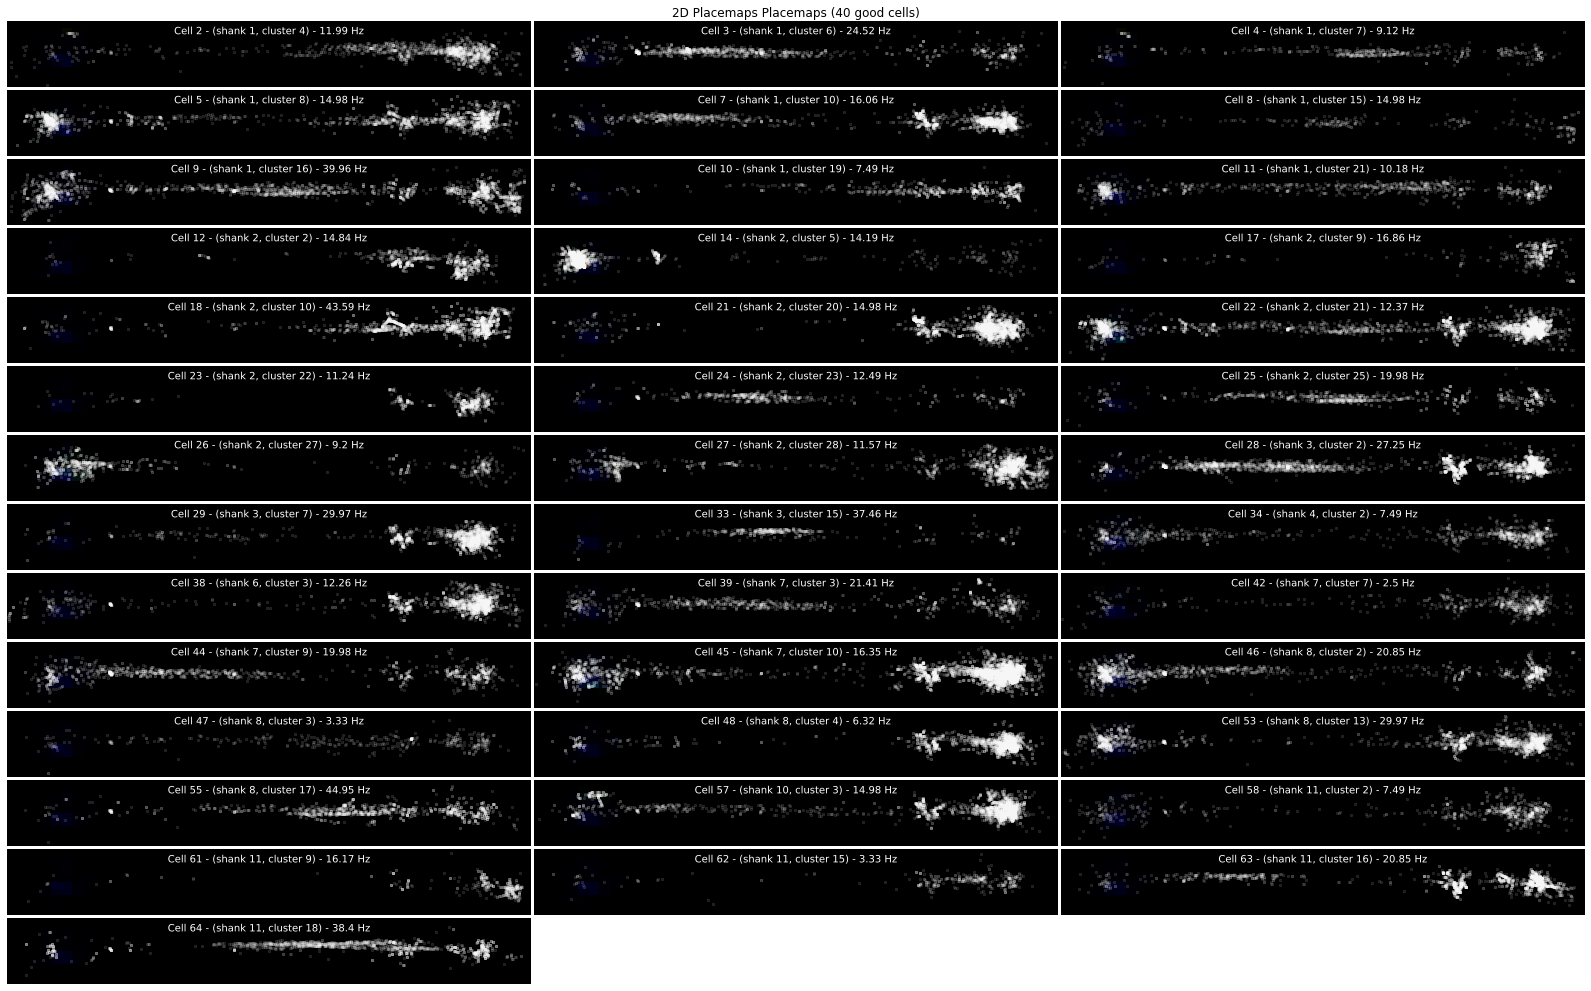

In [10]:
from neuropy.plotting.ratemaps import plot_ratemap_2D, enumTuningMap2DPlotVariables, enumTuningMap2DPlotMode

curr_fig_resolution_multiplier = 1.0
curr_fig_column_width=8.0
curr_fig_row_height=1.0

plotted_unit_indicies=None # all # good subplots=(10,5)
# curr_subplots=(10,5)
# curr_single_plot_size=(4,1)
# curr_figsize=(30,30)

# plotted_unit_indicies=np.arange(5) # good subplots=(3,3)
# curr_subplots=(3,2)
# curr_figsize=(30,10)

# plotted_unit_indicies=[1] # good subplots=(3,3)
# curr_subplots=(1,1)
# curr_figsize=(30,10)

# plotted_unit_indicies=np.arange(8)
# curr_subplots=(2,3)
# curr_figsize=(30,10)

# plotted_unit_indicies=np.arange(8+6)
# curr_subplots=(2,3)
# curr_figsize=(30,10)

# plotted_unit_indicies=np.arange(8)
# curr_subplots=(10,3)
# curr_figsize=(30,10)
# fig = plt.figure(fignum + fig_ind, figsize=active_figure_size, dpi=None, clear=True, facecolor='r')

# plot_ratemap_2D(active_epoch_placefields2D.ratemap, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, figsize=(30, 30), subplots=(4,20), enable_spike_overlay=True, spike_overlay_spikes=active_epoch_placefields2D.spk_pos)
# plot_ratemap_2D(active_epoch_placefields2D.ratemap, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, figsize=(30, 10), subplots=(2,3), enable_spike_overlay=True, spike_overlay_spikes=active_epoch_placefields2D.spk_pos, included_unit_indicies=np.arange(8))


# plot_ratemap_2D(active_epoch_placefields2D.ratemap, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, plot_mode=enumTuningMap2DPlotMode.IMSHOW, figsize=curr_figsize, subplots=curr_subplots, enable_spike_overlay=True, spike_overlay_spikes=active_epoch_placefields2D.spk_pos, included_unit_indicies=plotted_unit_indicies)
# plot_ratemap_2D(active_epoch_placefields2D.ratemap, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, plot_mode=enumTuningMap2DPlotMode.PCOLORFAST, figsize=curr_figsize, subplots=curr_subplots, enable_spike_overlay=True, spike_overlay_spikes=active_epoch_placefields2D.spk_pos, included_unit_indicies=plotted_unit_indicies)

# plot_ratemap_2D(active_epoch_placefields2D.ratemap, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, plot_mode=enumTuningMap2DPlotMode.IMSHOW, figsize=curr_figsize, subplots=curr_subplots, enable_spike_overlay=True, spike_overlay_spikes=active_epoch_placefields2D.spk_pos, included_unit_indicies=plotted_unit_indicies)
# plot_ratemap_2D(active_epoch_placefields2D.ratemap, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, plot_mode=enumTuningMap2DPlotMode.PCOLORFAST, figsize=curr_figsize, subplots=curr_subplots, enable_spike_overlay=True, spike_overlay_spikes=active_epoch_placefields2D.spk_pos, included_unit_indicies=plotted_unit_indicies)

plot_ratemap_2D(active_epoch_placefields2D.ratemap, fig_column_width=curr_fig_column_width, fig_row_height=curr_fig_row_height, resolution_multiplier=curr_fig_resolution_multiplier, subplots=(None, 3), enable_spike_overlay=True, spike_overlay_spikes=active_epoch_placefields2D.spk_pos, included_unit_indicies=plotted_unit_indicies)

Saving 1D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.10\pf1D-Placefield1D-maze-speedThresh_0.00-gridBin_5.00-smooth_0.00-frateThresh_0.png"...	 done.
Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.10\pf2D-Occupancy-maze-speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.png"...	 done.
data_aspect_ratio: (8.0, Width_Height_Tuple(width=240.0, height=30.0))
page_grid_sizes: [RowColTuple(num_rows=14, num_columns=3)]
resolution_multiplier: 1.0, required_figure_size: (24.0, 14.0)
page_idx: 0


ValueError: alpha must be between 0 and 1, inclusive, but min is nan, max is nan

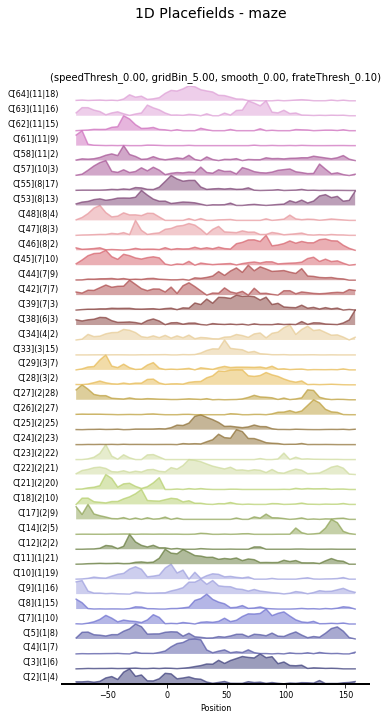

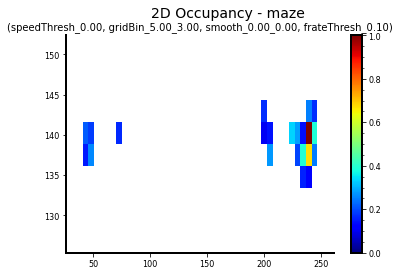

C:\Users\Pho\anaconda3\envs\phoviz_test\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


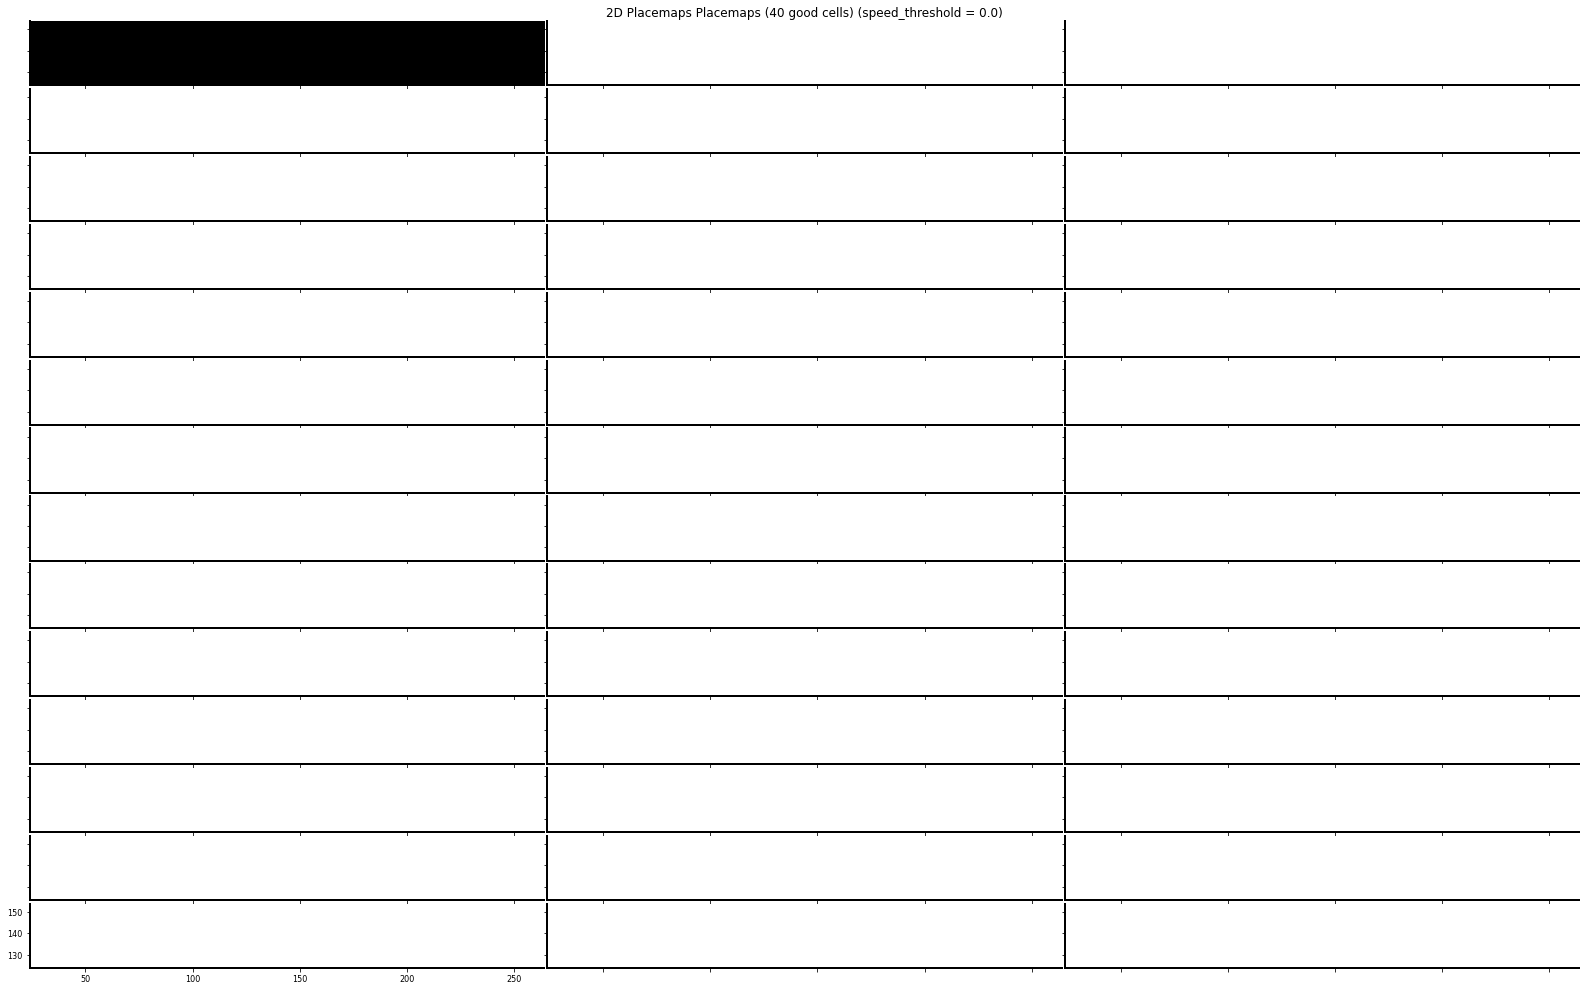

In [195]:
ax_pf_1D, occupancy_fig, active_pf_2D_figures, active_pf_2D_gs = plot_all_placefields(active_epoch_placefields1D, active_epoch_placefields2D, active_config, should_save_to_disk=should_save_to_disk)

Saving 1D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.10\pf1D-Placefield1D-maze-any_lap-speedThresh_0.00-gridBin_5.00-smooth_0.00-frateThresh_0.png"...	 done.
Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.10\pf2D-Occupancy-maze-any_lap-speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.png"...	 done.
data_aspect_ratio: 9.375000000000052
page_grid_sizes: [RowColTuple(num_rows=14, num_columns=3)]
resolution_multiplier: 1.0, required_figure_size: (24.0, 14.0)
page_idx: 0
Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.10\pf2D-Placefields-maze-any_lap-speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.png"...

C:\Users\Pho\repos\NeuroPy\neuropy\plotting\placemaps.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  aFig.savefig(active_pf_2D_output_filepath)


	 done.


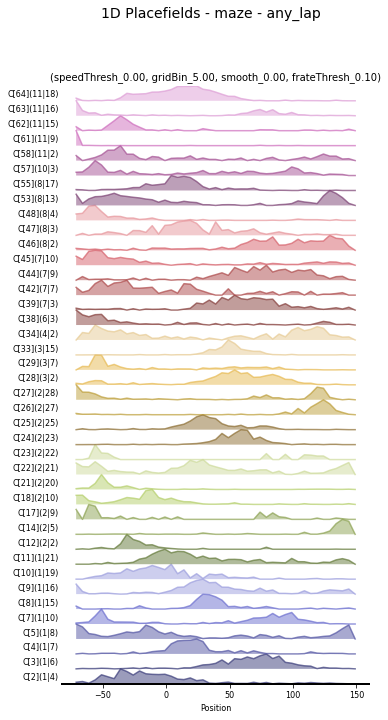

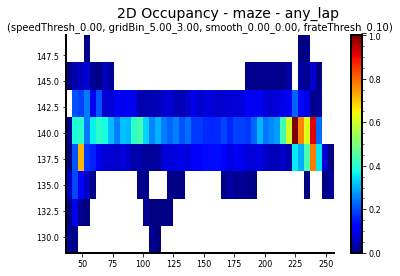

C:\Users\Pho\anaconda3\envs\phoviz_test\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


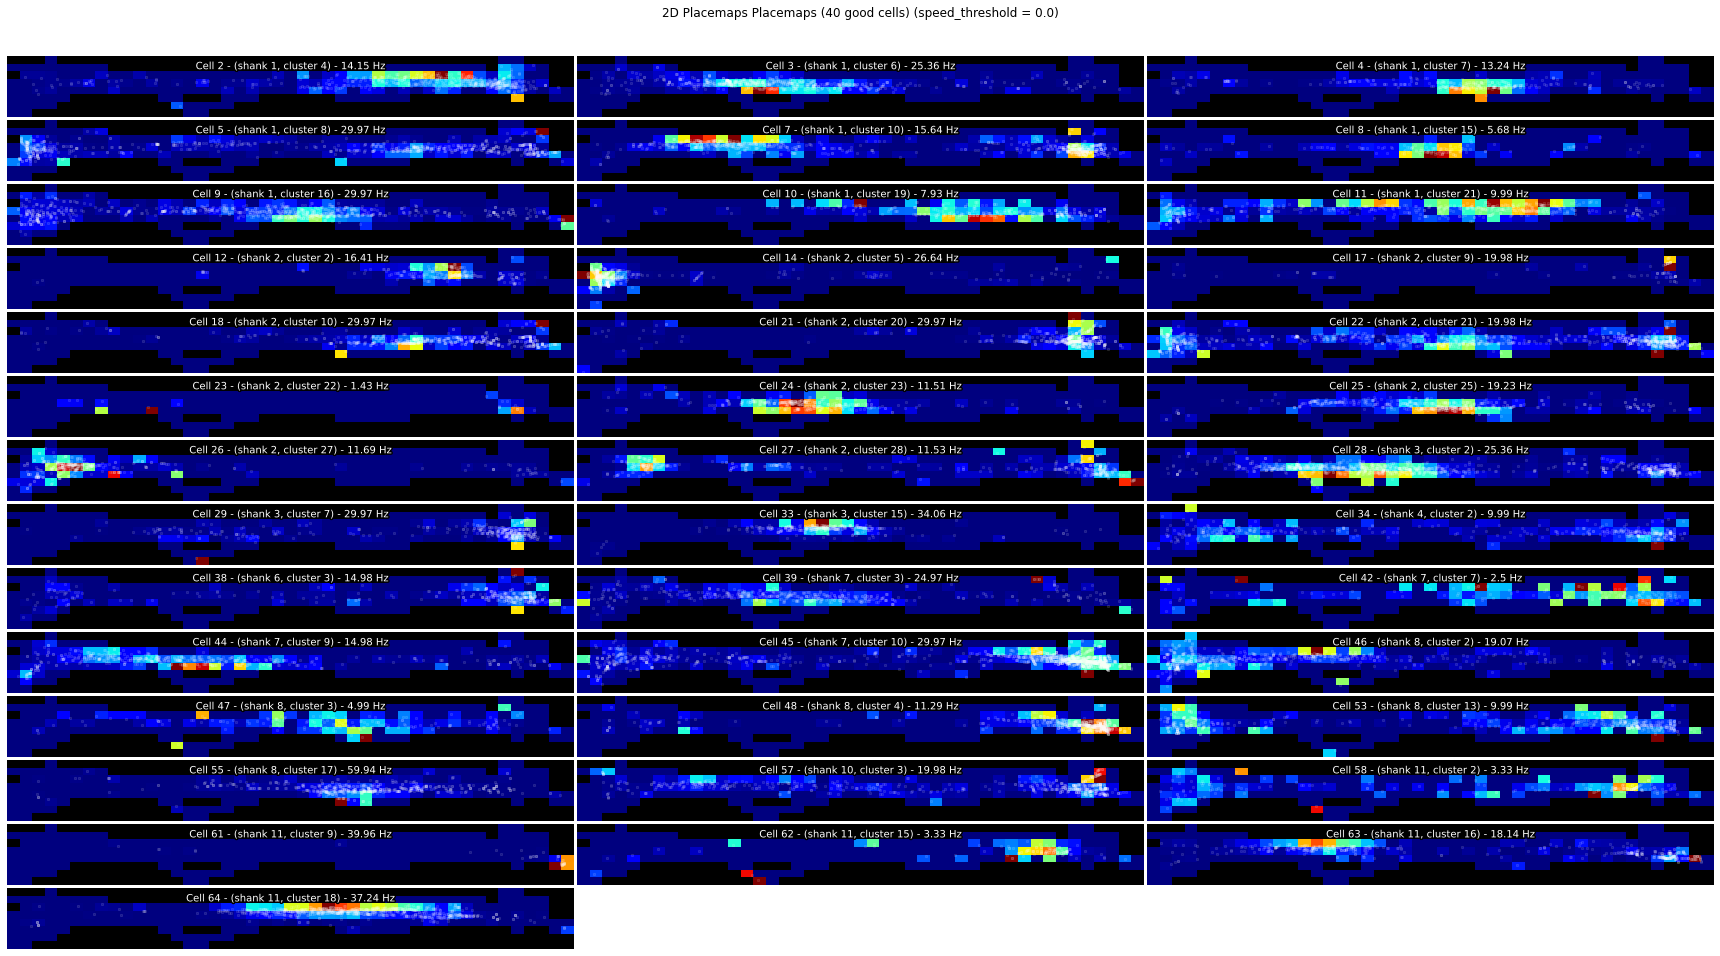

In [17]:
any_lap_specific_ax_pf_1D, any_lap_specific_occupancy_fig, any_lap_specific_active_pf_2D_figures, any_lap_specific_active_pf_2D_gs = plot_all_placefields(any_lap_specific_placefields1D, any_lap_specific_placefields2D, active_config, variant_identifier_label='any_lap', should_save_to_disk=should_save_to_disk);

Saving 1D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.10\pf1D-Placefield1D-maze-even_laps-speedThresh_0.00-gridBin_5.00-smooth_0.00-frateThresh_0.png"...	 done.
Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.10\pf2D-Occupancy-maze-even_laps-speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.png"...	 done.
data_aspect_ratio: 8.958333333333382
page_grid_sizes: [RowColTuple(num_rows=14, num_columns=3)]
resolution_multiplier: 1.0, required_figure_size: (24.0, 14.0)
page_idx: 0
Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.10\pf2D-Placefields-maze-even_laps-speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.png"...

C:\Users\Pho\repos\NeuroPy\neuropy\plotting\placemaps.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  aFig.savefig(active_pf_2D_output_filepath)


	 done.


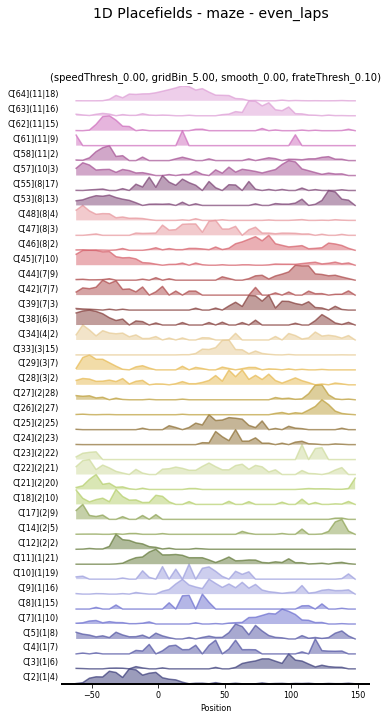

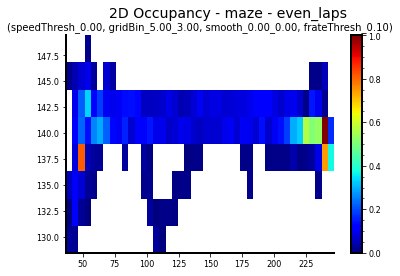

C:\Users\Pho\anaconda3\envs\phoviz_test\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


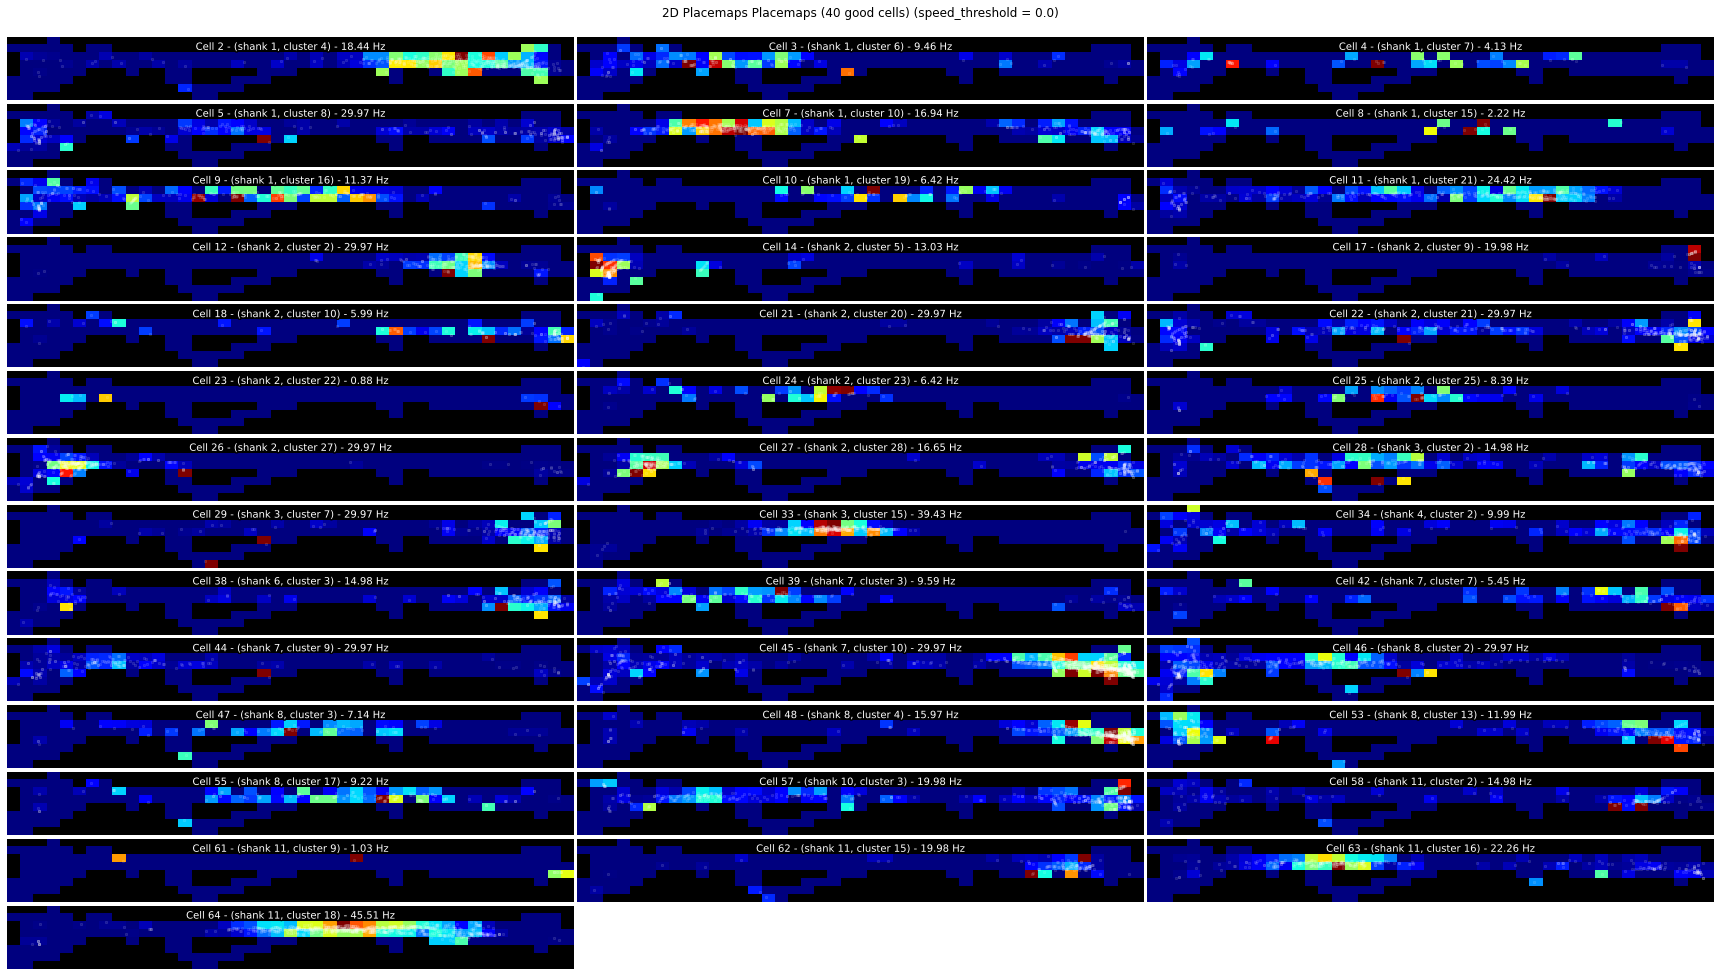

In [18]:
even_lap_specific_ax_pf_1D, even_lap_specific_occupancy_fig, even_lap_specific_active_pf_2D_figures, even_lap_specific_active_pf_2D_gs = plot_all_placefields(even_lap_specific_placefields1D, even_lap_specific_placefields2D, active_config, variant_identifier_label='even_laps', should_save_to_disk=should_save_to_disk);

Saving 1D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.10\pf1D-Placefield1D-maze-odd_laps-speedThresh_0.00-gridBin_5.00-smooth_0.00-frateThresh_0.png"...	 done.
Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.10\pf2D-Occupancy-maze-odd_laps-speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.png"...	 done.
data_aspect_ratio: 12.222222222222221
page_grid_sizes: [RowColTuple(num_rows=14, num_columns=3)]
resolution_multiplier: 1.0, required_figure_size: (24.0, 14.0)
page_idx: 0
Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.10\pf2D-Placefields-maze-odd_laps-speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.png"...

C:\Users\Pho\repos\NeuroPy\neuropy\plotting\placemaps.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  aFig.savefig(active_pf_2D_output_filepath)


	 done.


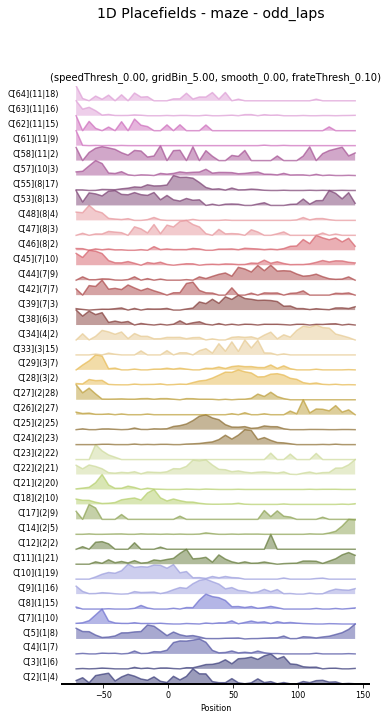

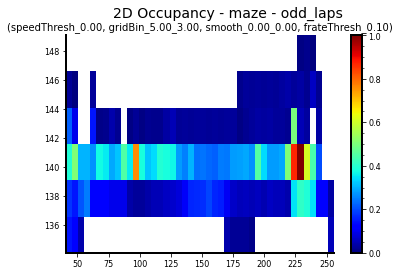

C:\Users\Pho\anaconda3\envs\phoviz_test\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


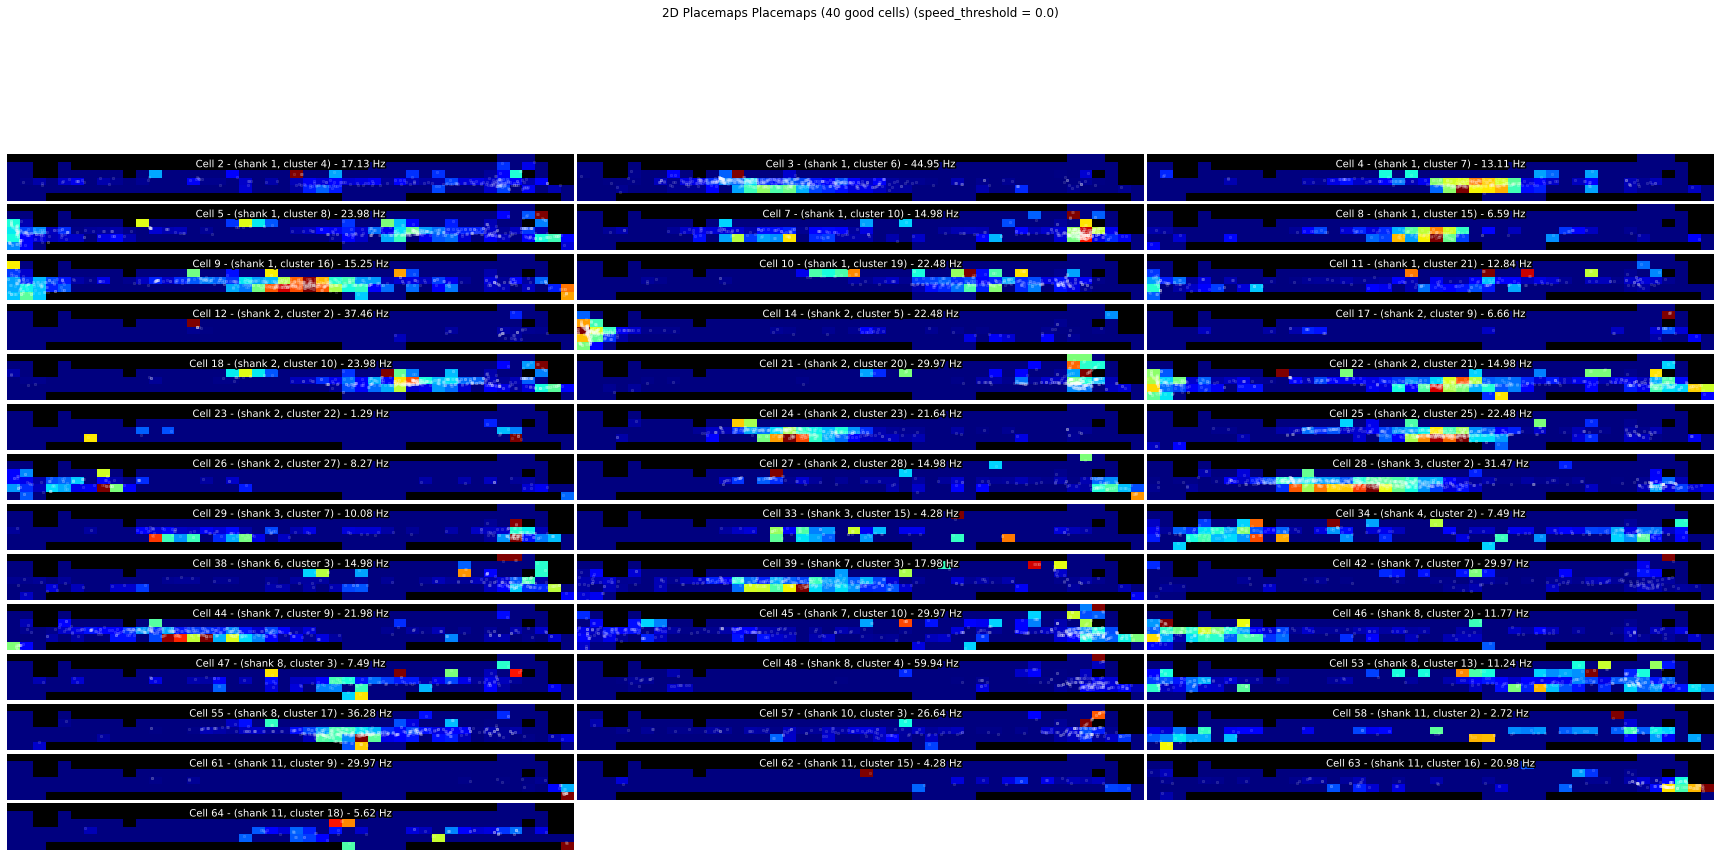

In [19]:
odd_lap_specific_ax_pf_1D, odd_lap_specific_occupancy_fig, odd_lap_specific_active_pf_2D_figures, odd_lap_specific_active_pf_2D_gs = plot_all_placefields(odd_lap_specific_placefields1D, odd_lap_specific_placefields2D, active_config, variant_identifier_label='odd_laps', should_save_to_disk=should_save_to_disk);

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Custom Occupancy'}>)

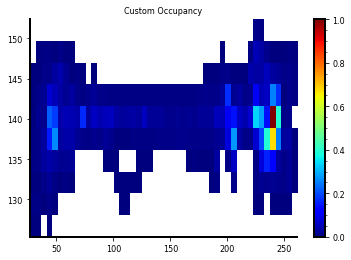

In [199]:
from neuropy.plotting.placemaps import plot_occupancy_custom, plot_placefield_occupancy


def test_plot_occupancy(active_placefields, should_overlay_animal_trajectory=True):
    occupancy_fig = plt.Figure(figsize=(10,6))
    occupancy_fig, occupancy_ax = plot_occupancy_custom(active_placefields.occupancy, active_placefields.ratemap.xbin_centers, active_placefields.ratemap.ybin_centers, max_normalized=True, fig=occupancy_fig)
    if should_overlay_animal_trajectory:
        # overlay animal position information to make sure they line up.
        occupancy_ax.scatter(active_placefields.x, active_placefields.y, s=5, c='red', alpha=0.1)
    return occupancy_fig, occupancy_ax


# plot_occupancy_1D(even_lap_specific_placefields1D, True)
# plot_occupancy_1D(even_lap_specific_placefields1D, False)
# plot_placefield_occupancy(even_lap_specific_placefields2D)

active_placefields = deepcopy(active_epoch_placefields2D)
# active_placefields = deepcopy(even_lap_specific_placefields2D)

# occupancy_fig, occupancy_ax = test_plot_occupancy(active_placefields, should_overlay_animal_trajectory=True)
# occupancy_fig, occupancy_ax = test_plot_occupancy(active_placefields, should_overlay_animal_trajectory=False)
# occupancy_fig

plot_placefield_occupancy(active_placefields)

# # fig = plt.Figure()
# fig, axs = plt.subplots(3, 1, figsize=(7, 15))

# # even_lap_specific_placefields1D.occupancy.
# # even_lap_specific_placefields1D.ratemap.xbin_centers
# # np.shape(even_lap_specific_placefields1D.ratemap.xbin) # (214,)
# # even_lap_specific_placefields1D.config.grid_bin_1D # 1
# # np.shape(even_lap_specific_placefields1D.ratemap.xbin_centers) # 213

# even_lap_specific_ax_pf_1D, even_lap_specific_occupancy_fig, even_lap_specific_active_pf_2D_figures = plot_all_placefields(even_lap_specific_placefields1D, even_lap_specific_placefields2D, active_config, variant_identifier_label='even_laps')

# even_lap_specific_placefields1D.plot_ratemaps();
# even_lap_specific_placefields1D.plot_ratemaps()

# Pho Custom Placefield2D Implementation:


In [ ]:
## TODO: re-computed the simple spike-count "raw" tuning maps to make sure that the spikes actually fall into the bins with high counts. This will help debug both the computations and the plots.

from neuropy.analyses.placefields import Pf2D
from neuropy.core.ratemap import Ratemap

spk_df = deepcopy(active_epoch_session.spikes_df)

xbin = active_epoch_placefields2D.ratemap.xbin.copy()
ybin = active_epoch_placefields2D.ratemap.ybin.copy()
occupancy = active_epoch_placefields2D.occupancy.copy()

neuron_split_spike_dfs = [spk_df.groupby('aclu').get_group(neuron_id)[['t','x','y','lin_pos']] for neuron_id in active_epoch_session.neuron_ids] # dataframes split for each ID:
firing_maps = np.asarray([Pf2D._compute_tuning_map(neuron_split_spike_dfs[i].x.to_numpy(), neuron_split_spike_dfs[i].y.to_numpy(), xbin, ybin, occupancy, None, should_return_raw_tuning_map=True) for i in np.arange(len(neuron_split_spike_dfs))]) # dataframes split for each ID:
tuning_maps = np.asarray([firing_maps[i] / occupancy for i in np.arange(len(firing_maps))])
ratemap = Ratemap(tuning_maps, xbin=xbin, ybin=ybin, neuron_ids=active_epoch_session.neuron_ids)

## TODO: This is where I should I try to plot the 2D map and the spikes and see if they line up
test_i = 9
fig, ax = plot_occupancy_custom(firing_maps[test_i], xbin, ybin, max_normalized=False)
ax.scatter(neuron_split_spike_dfs[test_i]['x'], neuron_split_spike_dfs[test_i]['y'], s=1, alpha=0.5)

## LOOKS GOOD! They line up well!

In [ ]:
## Check Firing Maps (separate from Occupancy maps)

## TODO: This is where I should I try to plot the 2D map and the spikes and see if they line up
test_i = 9
fig, ax = plot_occupancy_custom(firing_maps[test_i], xbin, ybin, max_normalized=False)
ax.scatter(neuron_split_spike_dfs[test_i]['x'], neuron_split_spike_dfs[test_i]['y'], s=1, alpha=0.5)

In [ ]:
# Group and Plot the different occupancy maps to compare them:
occupany_tabs = pn.Tabs(('All', occupancy_fig))
# Add multiple tabs
occupany_tabs.extend([
    ('Any Laps', any_lap_specific_occupancy_fig),
    ('Even Laps', even_lap_specific_occupancy_fig),
    ('Odd Laps', odd_lap_specific_occupancy_fig)
])

occupany_tabs

In [ ]:
pf_1D_plots_row = pn.Row(ax_pf_1D[0].get_figure(), any_lap_specific_ax_pf_1D[0].get_figure(), even_lap_specific_ax_pf_1D[0].get_figure(), odd_lap_specific_ax_pf_1D[0].get_figure())
pf_1D_plots_tab = pn.Column('# Pf 1D Plots', pf_1D_plots_row)

pf_2D_plots_tab = pn.Column('# Pf 2D Plots', pn.Row(active_pf_2D_figures[0], any_lap_specific_active_pf_2D_figures[0], even_lap_specific_active_pf_2D_figures[0], odd_lap_specific_active_pf_2D_figures[0]))

occupancy_plots_row = pn.Row(occupancy_fig, any_lap_specific_occupancy_fig, even_lap_specific_occupancy_fig, odd_lap_specific_occupancy_fig)
occupancy_plots_tab = pn.Column('# Occupancy Plots', occupancy_plots_row)

tabs = pn.Tabs()
# Add multiple tabs
tabs.extend([
    ('Occupancy', occupancy_plots_tab),
    ('Pf_1d', pf_1D_plots_tab),
    ('Pf_2d', pf_2D_plots_tab)
    
    # ('Text', pn.widgets.TextInput()),
    # ('Color', pn.widgets.ColorPicker())
])

tabs

In [ ]:
# print(np.unique(spk_df['aclu']))
# print(np.unique(spk_df['unit_id']))

curr_unit_idx = 3
def plot_ratemap(curr_unit_idx = 3):
    fig = Figure(figsize=(10, 6))
    ax = fig.subplots()
    mesh_X, mesh_Y = np.meshgrid(ratemap.xbin, ratemap.ybin)
    pfmap = ratemap.tuning_curves[curr_unit_idx]
    curr_pfmap = np.array(pfmap)
    curr_pfmap = np.rot90(np.fliplr(curr_pfmap)) / np.nanmax(curr_pfmap)
    ax.pcolormesh(mesh_X, mesh_Y, curr_pfmap, cmap='jet', vmin=0);
    ax.set_title(f'TuningCurve[{curr_unit_idx}]')
    pn.pane.Matplotlib(fig)
    return fig

# plot_ratemap(5)
# pn.interact(plot_ratemap, curr_unit_idx=3)
pn.interact(plot_ratemap, curr_unit_idx=widgets.IntSlider(start=0,end=ratemap.n_neurons,step=1,value=10))



## Main Spike/Placemap plotting:

# 2D Lap Plotting

### 2D Lap Trajectories Visualization:

## 2D Placefield Plotting:

In [ ]:
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
from PhoPositionalData.plotting.placefield import plot_1d_placecell_validations
# out_figures_list = plot_1d_placecell_validations(active_epoch_placefields1D, active_config.plotting_config, should_save=True, save_mode='pdf')
# out_figures_list = plot_1d_placecell_validations(active_epoch_placefields1D, active_config.plotting_config, should_save=True, save_mode='separate_files')
out_figures_list = plot_1d_placecell_validations(active_epoch_placefields1D, active_config.plotting_config, modifier_string='lap_only', should_save=False)


In [ ]:
out_figures_list = plot_1d_placecell_validations(even_lap_specific_placefields1D, active_config.plotting_config, should_save=False, save_mode='separate_files')

In [ ]:
# active_epoch_placefields2D.plotRaw()
curr_cell_id = 39
fig, ax = active_epoch_placefields2D.plotRaw_v_time(curr_cell_id)
# ax[0].plot(t_both, x_both, 'k', alpha=0.8, linewidth=5)
# ax[0].plot(t_even, x_even, 'g', alpha=0.3, linewidth=3)
# ax[0].plot(t_odd, x_odd, 'r', alpha=0.3, linewidth=3)

In [ ]:
active_epoch_placefields2D.plot_ratemaps_2D(figsize=(12,20), enable_spike_overlay=True)

In [ ]:
from PhoPositionalData.plotting.laps import plot_lap_trajectories_2d
fig, axs, laps_pages = plot_lap_trajectories_2d(sess, curr_num_subplots=len(sess.laps.lap_id), active_page_index=0)
fig.suptitle('Lap Trajectories 2D', fontsize=22)
# fig_out_path = active_config.plotting_config.get_figure_save_path('lap_trajectories_2D').with_suffix('.png')
# fig.savefig(fig_out_path)
plt.show()

# p, axs, laps_pages = plot_lap_trajectories_2d(sess, curr_num_subplots=22, active_page_index=0)
# p, axs, laps_pages = plot_lap_trajectories_2d(sess, curr_num_subplots=22, active_page_index=1)

# 3D Plots

### 3D Lap Trajectories Visualization:

In [8]:
from PhoPositionalData.plotting.laps import plot_lap_trajectories_3d
p, laps_pages = plot_lap_trajectories_3d(sess, curr_num_subplots=10, active_page_index=1)
p.show()

## Tuning Curves 3D Plot:

In [270]:
from PhoGui.InteractivePlotter.InteractivePlaceCellTuningCurvesDataExplorer import InteractivePlaceCellTuningCurvesDataExplorer
try: pActiveTuningCurvesPlotter
except NameError: pActiveTuningCurvesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipcDataExplorer = InteractivePlaceCellTuningCurvesDataExplorer(active_config, active_epoch_session, active_epoch_placefields2D, active_config.plotting_config.pf_colors, extant_plotter=pActiveTuningCurvesPlotter)
pActiveTuningCurvesPlotter = ipcDataExplorer.plot(pActiveTuningCurvesPlotter) # [2, 17449]

# def update_included_cell_ids(curr_unit_idx, show_spikes):
def update_included_cell_Indicies(included_cell_INDEXES, show_spikes=False):
    # included_cell_INDEXES = [curr_unit_idx]
    # included_cell_INDEXES = [ipcDataExplorer.get_cell_id_and_idx(cell_id=an_included_cell_ID)[0] for an_included_cell_ID in included_cell_ids]
    included_cell_ids = [ipcDataExplorer.get_neuron_id_and_idx(neuron_i=an_included_cell_idx)[1] for an_included_cell_idx in included_cell_INDEXES]
    # print(included_cell_ids)
    ipcDataExplorer.update_active_placefields(included_cell_INDEXES) # actives only the placefields that have aclu values (cell ids) in the included_cell_ids array.
    if show_spikes:
        ipcDataExplorer.update_active_spikes(np.isin(ipcDataExplorer.active_session.spikes_df['aclu'], included_cell_ids))
    else:
        ipcDataExplorer.update_active_spikes(np.isin(ipcDataExplorer.active_session.spikes_df['aclu'], []))

    ipcDataExplorer.gui['debug_console_widget'].add_line_to_buffer(f'cell_i: {included_cell_INDEXES}, cell_id: {included_cell_ids}')
    # pn.pane.Matplotlib(fig)


    

Applying custom Pyvista theme.
done.
No open BackgroundPlotter
Creating a new BackgroundPlotter
num_curr_tuning_curves: 40
self.params.debug_disable_all_gui_controls is True, so no gui controls will be built.


In [ ]:
def debug_plot_2d_binning(xbin, ybin, xbin_center, ybin_center):
    """ 
    Usage: 
        fig = debug_plot_2d_binning(active_epoch_placefields2D.ratemap.xbin, active_epoch_placefields2D.ratemap.ybin, active_epoch_placefields2D.ratemap.xbin_centers, active_epoch_placefields2D.ratemap.ybin_centers)
    """
    fig = plt.Figure(figsize=(10, 10))
    xmin = min(np.min(xbin), np.min(xbin_center))
    xmax = max(np.max(xbin), np.max(xbin_center))
    ymin = min(np.min(ybin), np.min(ybin_center))
    ymax = max(np.max(ybin), np.max(ybin_center))
    
    plt.hlines(ybin, xmin, xmax, colors='b', linestyles='solid', label='ybin')
    plt.hlines(ybin_center, xmin, xmax, colors='cyan', linestyles='dashed', label='ybin_center')
    plt.vlines(xbin, ymin, ymax, colors='r', linestyles='solid', label='xbin')
    plt.vlines(xbin_center, ymin, ymax, colors='pink', linestyles='dashed', label='xbin_center')
    
    plt.xticks(xbin)
    plt.yticks(ybin)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    fig = plt.gcf()
    fig.set_dpi(180)
    return fig

debug_plot_2d_binning(active_epoch_placefields2D.ratemap.xbin, active_epoch_placefields2D.ratemap.ybin, active_epoch_placefields2D.ratemap.xbin_centers, active_epoch_placefields2D.ratemap.ybin_centers)

In [82]:
from neuropy.plotting.ratemaps import compute_data_extent, compute_data_aspect_ratio, corner_points_from_extents

extent = compute_data_extent(active_epoch_placefields2D.ratemap.xbin, active_epoch_placefields2D.ratemap.ybin)
xmin, xmax, ymin, ymax = extent
print(f'xmin={xmin}, xmax={xmax}, ymin={ymin}, ymax={ymax}')
# compute_aspect_ratio(active_epoch_placefields2D.ratemap.xbin, active_epoch_placefields2D.ratemap.ybin) # returns (8.0, Width_Height_Tuple(width=240.0, height=30.0))

points = corner_points_from_extents(extent)
# points = corner_points_from_extents(extent)
# points = corner_points_from_extents([23, 260, 124, 154])

# points = corner_points_from_extents([23, 260, 124, 154, 0, 1])
print(f'points: {points}, np.shape(points): {np.shape(points)}') # np.shape(points): (4, 2)


point_x = points[:,0]
point_y = points[:,1]

print(f'point_x: {point_x}, np.shape(point_x): {np.shape(point_x)}') # np.shape(points): (4, 2)

xmin=23.923329354140844, xmax=263.92332935414083, ymin=123.85967782096927, ymax=153.85967782096927
extent_pairs_list: [[23.923329354140844, 263.92332935414083], [123.85967782096927, 153.85967782096927]]
points: [[ 23.92332935 123.85967782]
 [ 23.92332935 153.85967782]
 [263.92332935 123.85967782]
 [263.92332935 153.85967782]], np.shape(points): (4, 2)
point_x: [ 23.92332935  23.92332935 263.92332935 263.92332935], np.shape(point_x): (4,)


In [111]:
# load a sample texture
import pyvista.examples as pv_examples
sample_masonry_tex = pv_examples.download_masonry_texture()

# use the puppy image
sample_puppy_text = pv_examples.download_puppy_texture()

# Texture from file:
# image_file = examples.mapfile
image_file = r'output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.10\pf2D-Occupancy-maze-odd_laps-speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_0.png'
loaded_image_tex = pv.read_texture(image_file)


In [182]:
def plot_3d_image(p, xpoints, ypoints, data, z_location=0.0):
    """ Renders a 2D image such as a heatmap as a 3D plane """
    def _test_image(xx, yy):
        # create an image using numpy,
        # xx, yy = np.meshgrid(np.linspace(xmin, xmax, 2), np.linspace(ymin, ymax, 2))
        A, b = 500, 100
        zz = A * np.exp(-0.5 * ((xx / b) ** 2.0 + (yy / b) ** 2.0))

        # Creating a custom RGB image
        cmap = get_cmap(len(xx), name='nipy_spectral')
        norm = lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))
        hue = norm(zz.ravel())
        colors = (cmap(hue)[:, 0:3] * 255.0).astype(np.uint8)
        image = colors.reshape((xx.shape[0], xx.shape[1], 3), order="F")
        return image
    
    def _build_image(xx, yy, zz):
        # Creating a custom RGB image
        cmap = get_cmap(20, name='nipy_spectral')
        norm = lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))
        hue = norm(zz.ravel())
        colors = (cmap(hue)[:, 0:3] * 255.0).astype(np.uint8)
        image = colors.reshape((xx.shape[0], xx.shape[1], 3), order="F")
        return image
    
    

    extent2D = compute_data_extent(xpoints, ypoints)
    corner_points = corner_points_from_extents(extent2D)
    corner_points_x = corner_points[:,0]
    corner_points_y = corner_points[:,1]

    # Draw a plane with corners at the specified points:
    # build a structured grid out of the bins
    # twoDimGrid_x, twoDimGrid_y = np.meshgrid(xpoints, ypoints)
    twoDimGrid_x, twoDimGrid_y = np.meshgrid(corner_points_x, corner_points_y)
    # print(f'np.shape(twoDimGrid_x): {np.shape(twoDimGrid_x)}, np.shape(twoDimGrid_y): {np.shape(twoDimGrid_y)}')
        
    # grid = pv.StructuredGrid(twoDimGrid)
    # grid = pv.RectilinearGrid(twoDimGrid)
    # active_data = data[:,:].T.copy() # A single tuning curve
    # z_data = np.full_like(active_data, z_location)
    
    z_data = np.full_like(twoDimGrid_x, z_location)
    mesh = pv.StructuredGrid(twoDimGrid_x, twoDimGrid_y, z_data)
    # mesh["Elevation"] = (active_data.ravel(order="F") * zScalingFactor)
    # Map the curved surface to a plane - use best fitting plane
    mesh.texture_map_to_plane(inplace=True)

    # xmin, xmax, ymin, ymax = extent2D
    # image = _test_image(np.linspace(xmin, xmax, 20), np.linspace(ymin, ymax, 20))
    # image = _test_image(twoDimGrid_x, twoDimGrid_y)
    # image = _build_image(twoDimGrid_x, twoDimGrid_y, data)
    ## Get the 2D image as a texture to apply to the plane:
    # Convert 3D numpy array to texture
    # tex = pv.numpy_to_texture(image)
    # plotActor = mesh.plot(texture=tex, name='plot_3d_image_test')
    tex = loaded_image_tex
    plotActor = p.add_mesh(mesh, name='plot_3d_image_test', texture=tex, show_edges=True, edge_color='k', nan_opacity=0.0, scalars=None, opacity=1.00, use_transparency=False, smooth_shading=False, show_scalar_bar=False, render=True)
    # p.enable_depth_peeling() # this fixes bug where it appears transparent even when opacity is set to 1.00
    return plotActor


plot_3d_image(pActiveTuningCurvesPlotter, active_epoch_placefields2D.ratemap.xbin, active_epoch_placefields2D.ratemap.ybin, active_epoch_placefields2D.ratemap.occupancy)

extent_pairs_list: [[23.923329354140844, 263.92332935414083], [123.85967782096927, 153.85967782096927]]


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0000018E800F9A00

In [116]:
# poly = data_dict['mesh']
pActiveTuningCurvesPlotter.add_mesh_slice(data_dict['mesh'])

# origin = poly.center
# origin[-1] -= poly.length / 3.0
# projected = poly.project_points_to_plane(origin=origin)

In [221]:
# def test(**kwargs):
#     # test(point_size=8, font_size=10, name='build_center_labels_test', shape_opacity=0.8, show_points=False)
#     print(kwargs)

def get_arguments_as_optional_dict(**kwargs):
    # test(point_size=8, font_size=10, name='build_center_labels_test', shape_opacity=0.8, show_points=False)
    # print(kwargs)
    # print(
    #     f'**({{{kwargs}}} | kwargs)'
    # )
    print(', **(' + f'{kwargs}' + ' | kwargs)')

# get_arguments_as_optional_dict(point_size=8, font_size=10, name='build_center_labels_test', shape_opacity=0.8, show_points=False)

get_arguments_as_optional_dict(point_labels=point_labeling_function, 
                                                                            point_mask=point_masking_function,
                                                                            shape='rounded_rect', shape_opacity= 0.5, show_points=False, name='OccupancyLabels')

, **({'point_labels': <function <lambda> at 0x0000018E817420D0>, 'point_mask': <function <lambda> at 0x0000018E8174F1F0>, 'shape': 'rounded_rect', 'shape_opacity': 0.5, 'show_points': False, 'name': 'OccupancyLabels'} | kwargs)


In [ ]:
active_epoch_placefields2D.ratemap.occupancy

In [238]:
# from PhoPositionalData.plotting.graphs import plot_3d_binned_bars, plot_point_labels


# # modified_xbin, modified_ybin, modified_data = prepare_binned_data_for_3d(active_epoch_placefields2D.ratemap.xbin, active_epoch_placefields2D.ratemap.ybin, active_epoch_placefields2D.ratemap.occupancy)
# # plotActors, data_dict = plot_3d_binned_data(pActiveTuningCurvesPlotter, modified_xbin, modified_ybin, modified_data)
# plotActors, data_dict = plot_3d_binned_bars(pActiveTuningCurvesPlotter, active_epoch_placefields2D.ratemap.xbin, active_epoch_placefields2D.ratemap.ybin, active_epoch_placefields2D.ratemap.occupancy,
#                                            drop_below_threshold=1E-6, name='Occupancy', opacity=0.75)

# # The full point shown:
# # point_labeling_function = lambda (a_point): return f'({a_point[0]:.2f}, {a_point[1]:.2f}, {a_point[2]:.2f})'
# # Only the z-values
# point_labeling_function = lambda a_point: f'{a_point[2]:.2f}'
# # point_masking_function = lambda points: points[:, 2] > 20.0

# point_masking_function = lambda points: points[:, 2] > 1E-6
# # mask = points[:, 0] > 20.0
# plotActors_CenterLabels, data_dict_CenterLabels = plot_point_labels(pActiveTuningCurvesPlotter, active_epoch_placefields2D.ratemap.xbin_centers, active_epoch_placefields2D.ratemap.ybin_centers, active_epoch_placefields2D.ratemap.occupancy, 
#                                                                     point_labels=point_labeling_function, 
#                                                                     point_mask=point_masking_function,
#                                                                     shape='rounded_rect', shape_opacity= 0.5, show_points=False, name='OccupancyLabels')





# plotActors, data_dict = ipcDataExplorer.perform_plot_ratemap_bars(pActiveTuningCurvesPlotter, active_epoch_placefields2D.ratemap)

# p.enable_depth_peeling() # this fixes bug where it appears transparent even when opacity is set to 1.00


# ipcDataExplorer.ratemap
plotActors, data_dict = ipcDataExplorer.plot_occupancy_bars()

drop_below_threshold: 1e-06
Masking 2 of 1920 elements.
name: plot_3d_binned_bars_Occupancy
plotActors: {'plot_3d_binned_bars_Occupancy': {'main': (vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0000018E84F5B580}}
plotActors_CenterLabels: {'plot_point_labels_OccupancyLabels': (vtkmodules.vtkRenderingCore.vtkActor2D)0000018E84F8EB80}
plotActors: {'plot_3d_binned_bars_Occupancy': {'main': (vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0000018E84F5B580}, 'plot_point_labels_OccupancyLabels': (vtkmodules.vtkRenderingCore.vtkActor2D)0000018E84F8EB80}


In [239]:
plotActors

# data_dict

{'plot_3d_binned_bars_Occupancy': {'main': (vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0000018E84F5B580},
 'plot_point_labels_OccupancyLabels': (vtkmodules.vtkRenderingCore.vtkActor2D)0000018E84F8EB80}

In [248]:
from PhoGui.InteractivePlotter.shared_helpers import PlotGroup, PlotGroupWrapper
# vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor, vtkmodules.vtkRenderingCore.vtkActor2D

In [256]:
plot_list = [plotActors['plot_3d_binned_bars_Occupancy']['main'], plotActors['plot_point_labels_OccupancyLabels']]
# plot_list

In [248]:
occupancy_bars_plotGroup = PlotGroupWrapper('3d_Occupancy_bars', {'plot_3d_binned_bars_Occupancy':plotActors['plot_3d_binned_bars_Occupancy']['main'], 'plot_point_labels_OccupancyLabels':plotActors['plot_point_labels_OccupancyLabels']})

In [265]:
# occupancy_bars_plotGroup.blocks.SetVisibility(0)
# for a_block in occupancy_bars_plotGroup.blocks:
# for name in occupancy_bars_plotGroup.blocks.keys():
#     a_block = occupancy_bars_plotGroup.blocks[name]
#     a_block.SetVisibility(0)

# occupancy_bars_plotGroup.plots


# for a_plot_name, a_plot in enumerate(plot_list):
#     a_plot.SetVisibility(0)

occupancy_bars_plotGroup.GetVisibility()
occupancy_bars_plotGroup.SetVisibility(1)
    
# for a_plot_name, a_plot in occupancy_bars_plotGroup.plots.items():
#     a_plot.SetVisibility(1)
    
    
# blocks = None
# blocks = pv.MultiBlock()
# blocks.append(plotActors['plot_3d_binned_bars_Occupancy']['main'])
# blocks.append(plotActors['plot_point_labels_OccupancyLabels'])

In [278]:

from PhoPositionalData.plotting.mixins.general_plotting_mixins import ActivePlacefieldsPlotting

class ActivePlacefieldsPlottingPanel(ActivePlacefieldsPlotting):
    
    should_update_on_value_change = True
    
    def __init__(self, num_pfs=40, **params):
        super(ActivePlacefieldsPlottingPanel, self).__init__(num_pfs=num_pfs, **params)
        self.num_pfs = num_pfs
        # self.figure = figure(x_range=(-1, 1), y_range=(-1, 1))
        # self.renderer = self.figure.line(*self._get_coords())

    @staticmethod
    def options_to_str(options_list_ints):
        return [f'{i}' for i in options_list_ints]
    
    @staticmethod
    def options_to_int(options_list_strings):
        return [int(a_str) for a_str in options_list_strings]
    
    @staticmethod
    def build_pf_options_list(num_pfs=40):
        pf_options_list_ints = np.arange(num_pfs)
        pf_options_list_strings = ActivePlacefieldsPlottingPanel.options_to_str(pf_options_list_ints) # [f'{i}' for i in pf_options_list_ints]
        return pf_options_list_ints, pf_options_list_strings

    # _on_hide_all_placefields = lambda x: print(f'_on_hide_all_placefields({x})')
    # _on_update_active_placefields = lambda x: print(f'_on_update_active_placefields({x})')

    def on_hide_all_placefields(self):
        print('on_hide_all_placefields()')
        update_included_cell_Indicies([])
        # lambda x: print(f'_on_hide_all_placefields({x})')

    def on_update_active_placefields(self, updated_pf_indicies):
        print(f'on_update_active_placefields({updated_pf_indicies})')
        update_included_cell_Indicies(updated_pf_indicies)

    def btn_hide_all_callback(self, event):
        print('btn_hide_all_callback(...)')
        self.on_hide_all_placefields()
        
    def btn_update_active_placefields(self, event):
        print('btn_update_active_placefields(...)')
        updated_pf_options_list_ints = ActivePlacefieldsPlottingPanel.options_to_int(self.cross_selector.value) # convert to ints
        self.on_update_active_placefields(updated_pf_options_list_ints)

    def index_selection_changed_callback(self, *events):
        # print(events)
        for event in events:
            if event.name == 'options':
                self.selections.object = 'Possible options: %s' % ', '.join(event.new)
            elif event.name == 'value':
                if ActivePlacefieldsPlottingPanel.should_update_on_value_change:
                    updated_pf_options_list_ints = ActivePlacefieldsPlottingPanel.options_to_int(event.new) # convert to ints
                    self.on_update_active_placefields(updated_pf_options_list_ints)
                    
                self.selected.object = 'Selected: %s' % ','.join(event.new)

    def panel(self):
        # Panel pane and widget objects:
        self.selections = pn.pane.Markdown(object='')
        self.selected = pn.pane.Markdown(object='')
        self.cross_selector = pn.widgets.CrossSelector(name='Active Placefields', value=[], options=['0', '1', '2'], height=600, width=200) # cross_selector.value

        # Action Buttons:
        self.button_hide_all = pn.widgets.Button(name='Hide All Placefields')
        self.button_hide_all.on_click(self.btn_hide_all_callback)
        self.button_update = pn.widgets.Button(name='Update Active Placefields', button_type='primary')
        self.button_update.on_click(self.btn_update_active_placefields)

        self.watcher = self.cross_selector.param.watch(self.index_selection_changed_callback, ['options', 'value'], onlychanged=False)
        # set initial
        active_new_pf_panel.set_initial(self.num_pfs, [0, 1, 5])

        return pn.Column(pn.Row(self.cross_selector, width=200, height=600),
                         pn.Spacer(width=200, height=10),
                         self.selections,
                         pn.Spacer(width=200, height=10),
                         self.selected,
                         pn.Spacer(width=200, height=20),
                         pn.Row(self.button_hide_all, self.button_update)
                        )
    
        # return pn.Row(pn.Column(self.cross_selector, width=200, height=600), self.selections, pn.Spacer(width=50, height=600), self.selected)

    def set_initial(self, num_pfs, selected_values):
        # set initial
        # options = ['A','B','C','D']
        # options = ['A','B','C','D']
        pf_options_list_ints, pf_options_list_strings = ActivePlacefieldsPlotting.build_pf_options_list(num_pfs)
        options = pf_options_list_strings
        selected_values = [str(an_item) for an_item in selected_values]
        # value=[]
        # self.cross_selector.param.set_param(options=dict(zip(options,options)), value=['D'])
        # self.cross_selector.param.set_param(options=dict(zip(options,options)), value=['D'])
        self.cross_selector.param.set_param(options=dict(zip(options, options)), value=selected_values)


active_new_pf_panel = ActivePlacefieldsPlottingPanel(num_pfs=40)
active_new_pf_panel.panel()

on_update_active_placefields([0, 1, 5])


on_update_active_placefields([0, 5]) 
on_update_active_placefields([0, 5, 19])

Column
    [0] Row(height=600, sizing_mode='fixed', width=200)
        [0] CrossSelector(height=600, name='Active Placefields', options={'0': '0', '1': '1', ...}, sizing_mode='fixed', value=['0', '1', '5'], width=200)
    [1] Spacer(height=10, sizing_mode='fixed', width=200)
    [2] Markdown(str)
    [3] Spacer(height=10, sizing_mode='fixed', width=200)
    [4] Markdown(str)
    [5] Spacer(height=20, sizing_mode='fixed', width=200)
    [6] Row
        [0] Button(name='Hide All Placefields')
        [1] Button(button_type='primary', name='Update Active P...)

### Tuning-Curve Height Spikes Plot Testing:

In [266]:
# # included_cell_ids = [2, 3, 14, 22, 29, 42, 48, 61]
# included_cell_ids = [14, 39]
# included_cell_INDEXES = [ipcDataExplorer.get_cell_id_and_idx(cell_id=an_included_cell_ID)[0] for an_included_cell_ID in included_cell_ids]
# print(included_cell_INDEXES)




# update_included_cell_ids(5)
# interact(update_included_cell_ids, curr_unit_idx=(0,(active_epoch_placefields2D.ratemap.n_neurons-1)))
interact(update_included_cell_ids, curr_unit_idx=(0,(active_epoch_placefields2D.ratemap.n_neurons-1)), show_spikes=False)
# interact_manual(update_included_cell_ids, curr_unit_idx=widgets.IntSlider(start=0, end=active_epoch_placefields2D.ratemap.n_neurons, step=1, value=10))

NameError: name 'interact' is not defined

In [ ]:
# def func1(x):
#     return 5*x

# # Create a grid around that surface
# grid = pv.create_grid(surface)
# # Clip the grid using the surface
# model = grid.clip_surface(surface)
# # Compute height and display it
# model.elevation().plot()


# interact(func1, x=(0,(active_epoch_placefields2D.ratemap.n_neurons-1)))

# # interact_manual(func1, x=(0,(active_epoch_placefields2D.ratemap.n_neurons-1)))
# # interact(func1, x=IntSlider(min=10, max=50, value=25, step=2, description="Integer Slider"))

item_layout = widgets.Layout(height='100px', min_width='40px')

items = [widgets.Button(layout=item_layout, description=str(i), button_style='success') for i in range(40)]

box_layout = widgets.Layout(overflow_x='scroll',
                    border='3px solid black',
                    width='500px',
                    height='',
                    flex_flow='row',
                    display='flex')
carousel = widgets.Box(children=items, layout=box_layout)
widgets.VBox([widgets.Label('Scroll horizontally:'), carousel])


In [ ]:
cell_idx_int_slider = widgets.IntSlider(min=0, max=(active_epoch_placefields2D.ratemap.n_neurons-1), value=10, step=1, description="Cell Index Int Slider")
cell_idx_int_slider

In [ ]:
interact(func1, x=cell_idx_int_slider)

In [ ]:
## Test Hiding/Showing Displayed Tuning Curves for Given CellIDs:
ipcDataExplorer.update_active_placefields(included_cell_INDEXES) # actives only the placefields that have aclu values (cell ids) in the included_cell_ids array.    

In [ ]:
## Test Hiding/Showing Display Spikes for Given CellIDs:
ipcDataExplorer.update_active_spikes(np.isin(ipcDataExplorer.active_session.spikes_df['aclu'], included_cell_ids))

In [ ]:
# Thicken the floor:
z_cells = np.array([25]*5 + [35]*3 + [50]*2 + [75, 100])
print(len(z_cells)) # 12
print(np.shape(ipcDataExplorer.x)) # (57247,)
z = np.zeros_like(ipcDataExplorer.x)
print(np.shape(z))
xx = np.repeat(ipcDataExplorer.x, len(z_cells), axis=-1)
yy = np.repeat(ipcDataExplorer.y, len(z_cells), axis=-1)
# zz = np.repeat(z, len(z_cells), axis=-1) - np.cumsum(z_cells).reshape((1, 1, -1))
zz = np.repeat([0.0], len(z_cells), axis=-1) - np.cumsum(z_cells).reshape((1, 1, -1))

mesh = pv.StructuredGrid(xx, yy, zz)
mesh["Elevation"] = zz.ravel(order="F")
mesh



In [ ]:

# np.where(np.logical_not(np.isnan(spike_pf_heights_2D[cell_i]))) # spike_pf_heights_2D: all NaN

# Add a custom z override for the spikes but with the default value so nothing is changed:
ipcDataExplorer.active_session.spikes_df['z'] = np.full_like(ipcDataExplorer.active_session.spikes_df['x'].values, 1.1) # Offset a little bit in the z-direction so we can see it

# set the z values for the current cell index to the heights offset for that cell:
ipcDataExplorer.active_session.spikes_df.loc[(ipcDataExplorer.active_session.spikes_df.aclu == curr_cell_id), 'z'] = spike_pf_heights_2D[cell_i]

ipcDataExplorer.update_spikes()
# ipcDataExplorer.plot()
# ipcDataExplorer.plots['spikes_pf_active'] = ipcDataExplorer.p.add_mesh(historical_spikes_pc, name='spikes_pf_active', scalars='cellID', cmap=ipcDataExplorer.active_config.plotting_config.active_cells_listed_colormap, show_scalar_bar=False, lighting=False, render=False)


# turn on specific pf: (aclu == 14)


In [ ]:
active_epoch_session.position

vectors = [[0, 0, 10.0]] * len(active_epoch_session.spikes_df['x']) # just up in the z-direction
spike_series_positions = active_epoch_session.spikes_df[['x','y']].to_numpy().T    
z_fixed = np.full_like(spike_series_positions[0,:], 1.1) # Offset a little bit in the z-direction so we can see it
origins = np.vstack((spike_series_positions[0,:], spike_series_positions[1,:], z_fixed)).T
# origins

# Perform ray trace
# Define line segment
# start = [0, 0, 0]
# stop = [0.25, 1, 0.5]

curr_idx = 0
curr_tuning_curve_mesh = ipcDataExplorer.plots['tuningCurvePlotActors'][curr_idx]
start = origins[curr_idx]
stop = start + vectors[curr_idx]


## Interactive 3D Spike and Behavior Browser: 

In [ ]:
import PhoGui
from PhoGui.InteractivePlotter.PhoInteractivePlotter import PhoInteractivePlotter
from PhoGui.InteractivePlotter.shared_helpers import InteractivePyvistaPlotterBuildIfNeededMixin
from PhoGui.InteractivePlotter.InteractivePlaceCellDataExplorer import InteractivePlaceCellDataExplorer

active_config.plotting_config.show_legend = True

try: pActiveInteractivePlaceSpikesPlotter
except NameError: pActiveInteractivePlaceSpikesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipspikesDataExplorer = InteractivePlaceCellDataExplorer(active_config, active_epoch_session, extant_plotter=pActiveInteractivePlaceSpikesPlotter)
pActiveInteractivePlaceSpikesPlotter = ipspikesDataExplorer.plot(pActivePlotter=pActiveInteractivePlaceSpikesPlotter)

## CustomDataExplorer 3D Plotter:

In [ ]:
from PhoGui.InteractivePlotter.InteractiveCustomDataExplorer import InteractiveCustomDataExplorer
active_laps_config = InteractivePlaceCellConfig(active_session_config=sess.config, active_epochs=None, video_output_config=None, plotting_config=None) # '3|1    
active_laps_config.plotting_config = PlottingConfig(output_subplots_shape='1|5', output_parent_dir=Path('output', sess.config.session_name, 'custom_laps'))

try: pActiveInteractiveLapsPlotter
except NameError: pActiveInteractiveLapsPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
iplapsDataExplorer = InteractiveCustomDataExplorer(active_laps_config, sess, extant_plotter=pActiveInteractiveLapsPlotter)
pActiveInteractiveLapsPlotter = iplapsDataExplorer.plot(pActivePlotter=pActiveInteractiveLapsPlotter)

In [ ]:
len(sess.laps.lap_id) # 44

In [ ]:
for i in np.arange(len(sess.laps.lap_id)):
    curr_lap_id = sess.laps.lap_id[i]
    curr_lap_t_start, curr_lap_t_stop = sess.laps.get_lap_times(i)
    curr_lap_position_traces = laps_position_traces[i]
    plot_lap_trajectory_path_spline(iplapsDataExplorer, curr_lap_position_traces, curr_lap_id)

In [ ]:
# p = pv.Plotter(shape=(5, 1), border=True)
p = pActiveInteractiveLapsPlotter
num_laps_to_show = len(sess.laps.lap_id)
num_laps_to_show = 5
flat_lap_id_index = np.arange(len(sess.laps.lap_id))
# subplot_lap_id_index = np.reshape([4,11])
for i in np.arange(num_laps_to_show):
    curr_lap_id = sess.laps.lap_id[i]
    p.subplot(i, 0)
    # curr_lap_t_start, curr_lap_t_stop = sess.laps.get_lap_times(i)
    plot_lap_trajectory_path_spline(iplapsDataExplorer, laps_position_traces[i], curr_lap_id)
    
p.link_views()  # link all the views
p.show()

In [ ]:
# def plot_placefields2D(pTuningCurves, active_placefields, pf_colors: np.ndarray, zScalingFactor=10.0, show_legend=False):

#     # .threshold().elevation()

#     curr_tuning_curves = active_placefields.ratemap.normalized_tuning_curves
#     # curr_tuning_curves[curr_tuning_curves < 0.1] = np.nan
#     curr_tuning_curves = curr_tuning_curves * zScalingFactor

#     num_curr_tuning_curves = len(curr_tuning_curves)
#     # Get the cell IDs that have a good place field mapping:
#     good_placefield_neuronIDs = np.array(active_placefields.ratemap.neuron_ids) # in order of ascending ID
#     tuningCurvePlot_x, tuningCurvePlot_y = np.meshgrid(active_placefields.ratemap.xbin_centers, active_placefields.ratemap.ybin_centers)

#     pdata_currActiveNeuronTuningCurve = pv.StructuredGrid(tuningCurvePlot_x, tuningCurvePlot_y, curr_active_neuron_tuning_Curve)
#     pdata_currActiveNeuronTuningCurve["Elevation"] = curr_active_neuron_tuning_Curve.ravel(order="F")
        
#     return pTuningCurves

# plot_placefields2D(pTuningCurves, active_epoch_placefields

# ipcDataExplorer.plots['spikes_pf_active']['cellID']

# only_active_colormap = ipcDataExplorer.active_config.plotting_config.active_cells_listed_colormap.copy()
# only_active_colormap
test_full_pc_data = ipcDataExplorer.plots_data['spikes_pf_active']['historical_spikes_pc']

# test_subset = test_full_pc_data.GetCellGhostArray()
# test_subset = test_full_pc_data.GetCellData() # vtkmodules.vtkCommonDataModel.vtkCellData
# test_subset = test_full_pc_data[test_full_pc_data['cellID'] == 55] # vtkmodules.vtkCommonDataModel.vtkCellData

# test_subset = test_full_pc_data.GetGhostArray() # [test_full_pc_data['cellID'] == 55] # vtkmodules.vtkCommonDataModel.vtkCellData


unique_ids = np.unique(test_full_pc_data['cellID']) # array([ 0,  1,  2,  3,  5,  7,  9, 10, 15, 16, 19, 20, 21, 22, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56])
# count_arr = np.bincount(test_full_pc_data['cellID'])
count_arr
# array([ 3591,  3311,   231,  4410,     0,   910,     0,  4417,     0,
#         1050,  2443,     0,     0,     0,     0,  2156,  6664,     0,
#            0, 10052,  6286,  2394,  1561,     0,     0,  8827,  4788,
#         6412,     0,     0,     0,   959,  2051,     0,     0,     0,
#         4809,  2758,     0,     0,  1575,     0,  3465, 14861,  2212,
#          777,  2772,     0,     0,     0,     0,  3206,     0,  4032,
#            0,  6489,  2674], dtype=int64)

# good_placefield_neuronIDs: [  5   8  10  13  14  16  19  21  23  25  28  31  32  33  36  37  41  49
#   52  53  54  55  57  59  60  61  62  63  64  66  68  69  74  75  76  78
#   83  86  88  89  90  92  96  98 105 108]; (46 good)

# 1, 4, 6, 7, 8, 11, 18, 19, 21 ## CONCLUSION: the ones that work are indeed the non-zero entries, but the checkboxes work in reverse order to this array that's printed. Meaning you start at the end and work back.
# len(count_arr) # 107
print(unique_ids) # [  3   6   8  11  12  14  17  19  21  23  26  29  30  31  34  35  39  47
  # 50  51  52  53  55  57  58  59  60  61  62  64  66  67  72  73  74  76
  # 81  84  86  87  88  90  94  96 103 106]


# uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['aclu'].values, return_index=True, return_inverse=True, return_counts=True)
# # count_arr = np.bincount(active_epoch_session.spikes_df['aclu'].values)
# print('active_epoch_session.spikes_df unique aclu values: {}'.format(uniques))
# print('active_epoch_session.spikes_df unique aclu value counts: {}'.format(count_arr))
# print(len(uniques)) # 46 
# uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['unit_id'].values, return_index=True, return_inverse=True, return_counts=True)
# # count_arr = np.bincount(active_epoch_session.spikes_df['unit_id'].values)
# print('active_epoch_session.spikes_df unique unit_id values: {}'.format(uniques))
# print('active_epoch_session.spikes_df unique unit_id value counts: {}'.format(count_arr))
# print(len(uniques)) # 46 

In [ ]:
# pActiveTuningCurvesPlotter.export_obj('export.obj')
# pActiveTuningCurvesPlotter.export_gltf('export.gltf')

ipcDataExplorer.update_placefield_spike_visibility([38], True) # seems to work

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([53], True) # seems to work

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([44, 53], True) # seems to work

# test_subset
# test_subset

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([53, 44], False) # seems to work

In [ ]:
ipcDataExplorer.gui['tuningCurveSpikeVisibilityCallbacks'][1](False)
# ipcDataExplorer.get_cell_index([2, 3])

In [ ]:
mesh = ipcDataExplorer.plots_data['spikes_pf_active']['historical_spikes_pc'].cast_to_unstructured_grid()
# mesh.n_cells
mesh_unique_ids = np.unique(mesh['cellID'])
print('n_cells: {}'.format(mesh.n_cells)) # 122143
print('cellIDs of mesh: {}'.format(mesh_unique_ids))
# np.unique(mesh['cellID']) # array([ 0,  1,  2,  3,  5,  7,  9, 10, 15, 16, 19, 20, 21, 22, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56])
# ipcDataExplorer.hide_placefield_spikes([0,1,2,3], should_invert=True)
# ipcDataExplorer.hide_placefield_spikes([23,2,34], should_invert=True)

# ipcDataExplorer.hide_placefield_spikes([34], should_invert=True)
ipcDataExplorer.hide_placefield_spikes([38], should_invert=False)

In [ ]:
# the list of spike times that occured for this cell:
i = 2
active_epoch_session.neurons.neuron_ids[i]
active_epoch_session.neurons.spiketrains[i]

# spikes_df = FlattenedSpiketrains.build_spike_dataframe(sess)


In [ ]:
## Timestamp Fixing:
def tt(position_timestamps, t_begin, SampleRate):
    return ((position_timestamps - t_begin) / (1e6 * SampleRate))

# sess.laps.lap_start_stop_flat_idx

sess.recinfo.dat_sampling_rate


# Programmatically change the animal position trail:

In [ ]:
curr_lap_id = int_input.value

# plot_lap_trajectory_path(ipspikesDataExplorer, curr_lap_position_traces)
plot_lap_trajectory_path_spline(ipspikesDataExplorer, curr_lap_position_traces)
# curr_lap_t_start
## TODO: enable showding/hiding the spikes for this data range programmatically in InteractivePlaceCellDataExplorer. 
# ipspikesDataExplorer.
# curr_lap_spike_t_seconds
# curr_lap_spike_indicies
# active_epoch_session.flattened_spiketrains.spikes_df.t_seconds.values[curr_lap_spike_indicies] # index 145937 is out of bounds for axis 0 with size 19647

In [ ]:
# From the laps and position dataframe, extract which lap every position belongs to:

# curr_lap_position_df_is_included = curr_position_df['t'].between(laps_df['start'], laps_df['stop'], inclusive=True) # returns a boolean array indicating inclusion in teh current lap
# curr_lap_position_df = curr_position_df[curr_lap_position_df_is_included] 
# curr_position_df['lap'] = np.NaN

curr_position_df = sess.compute_position_laps()
# curr_position_df.groupby('lap').groups[1] # returns the Int64Index
# curr_position_df.groupby('lap').get_group(2)[['t','x','y','lin_pos']]

lap_specific_position_dfs = [curr_position_df.groupby('lap').get_group(i)[['t','x','y','lin_pos']] for i in sess.laps.lap_id]
lap_specific_position_dfs
curr_lap_position_traces = [lap_pos_df[['x','y']].to_numpy().T for lap_pos_df in lap_specific_position_dfs]
curr_lap_position_traces
curr_lap_time_range = [[lap_pos_df[['t']].to_numpy()[0].item(), lap_pos_df[['t']].to_numpy()[-1].item()] for lap_pos_df in lap_specific_position_dfs]
curr_lap_time_range

In [ ]:
# .GetPosition() returns the actor's position, which is usually (0.0, 0.0, 0.0), and does not relate to the actor's data points
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetPosition()
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetXRange() # (44.23604202270508, 245.9059600830078)
# print(curr_animal_point)
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetYRange() # (135.27638244628906, 145.448974609375)
# print(curr_animal_point)
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetZRange() # (1.100000023841858, 1.100000023841858)

curr_animal_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # (206.27755737304688, 140.15452575683594, 1.100000023841858)
print('curr_animal_point: {}'.format(curr_animal_point))
curr_animal_point # curr_animal_point

# curr_animal_point = np.array([0, 0, 0])

# curr_animal_point = np.column_stack((self.x[active_window_sample_indicies], self.y[active_window_sample_indicies], self.z_fixed))
# ipspikesDataExplorer.on_programmatic_data_update(curr_animal_point=curr_animal_point)

curr_debug_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # (206.27755737304688, 140.15452575683594, 1.100000023841858)
ipspikesDataExplorer.perform_plot_location_point('debug_point_plot', curr_animal_point, color='r')

curr_animal_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # not updated
print('new curr_animal_point: {}'.format(curr_animal_point))

In [ ]:
# ipspikesDataExplorer.flattened_spike_positions_list

active_epoch_session.flattened_spiketrains.time_slice(curr_lap_spike_t_seconds.values[0], curr_lap_spike_t_seconds.values[-1]).spikes_df

In [ ]:
curr_lap_dataframe

In [ ]:
active_epoch_session.time_slice

In [ ]:
## Adding interaction highlighters:
pActiveInteractivePlaceSpikesPlotter.